# EDA and Modeling of Housing Prices in Ames, IA Using Regularized Regressions

The research question of interest is to accurately predict a house's sale price in Ames, IA. The resulting model can be used by buyers, sellers, and realtors to obtain an estimate of what a house is worth. 

In [116]:
import os

import pandas as pd
import numpy as np

from scipy.stats import skew
import math

from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sn

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline

import eli5

## Functions

In [2]:
def chart_gen(chart, bucket, col, df, features, target = None):
    """
    Uses the parameters to generate charts
    Parameters:
        chart (string): Chart type, options are hist, bar, and scatter
        bucket (int): if hist is chosen, the number of bins must be selected. If hist is not chosen,
        any value will work.
        col (int): number of charts to be in a single grid row for presentation purposes
        df (DataFrame): dataframe that the series are derived from
        features (list): list of features to be charted 
        target (string): name of target variable for scatter plot
    Returns:
        charts for the features chosen unless an incorrect chart name is given. Then a message
        requests the user to use a valid chart name.
    """
    if chart == 'hist':
        COUNT = 0
        fig = plt.figure(figsize=(25, 5))
        gs = GridSpec(nrows=1, ncols=col)

        for i in features:
            ax = fig.add_subplot(gs[0, COUNT])
            ax.hist(df[i], bins=bucket)
            plt.title("Histogram of " + str(i) + " Values")
            COUNT += 1

        plt.show()    
    
    elif chart == 'bar':
        COUNT = 0
        fig = plt.figure(figsize=(25, 5))
        gs = GridSpec(nrows=1, ncols=col)

        for i in features:
            counts = df[i].value_counts().sort_values()
            ax = fig.add_subplot(gs[0, COUNT])
            ax.bar(counts.index, counts)
            plt.xticks(rotation='vertical')
            plt.title("Histogram of " + str(i) + " Values")
            COUNT += 1
    
        plt.show()
        
    elif chart == 'box':
        COUNT = 0
        fig = plt.figure(figsize=(25, 5))
        gs = GridSpec(nrows=1, ncols=col)

        for i in features:
            ax = fig.add_subplot(gs[0, COUNT])
            ax.boxplot(df[i])
            plt.ylabel("Boxplot of " + str(i) + " Values")
            COUNT += 1
        
        fig.tight_layout()
        plt.show()
        
    elif chart == 'scatter':
        COUNT = 0
        fig = plt.figure(figsize=(25, 5))
        gs = GridSpec(nrows=1, ncols=col)

        for i in features:
            ax = fig.add_subplot(gs[0, COUNT])
            ax.scatter(df[i], df[target])
            plt.title("Scatter plot of " + str(i) + " and " + str(target))
            COUNT += 1
        
        fig.tight_layout()
        plt.show()
        
    elif chart == 'scatter-string':
        COUNT = 0
        fig = plt.figure(figsize=(25, 5))
        gs = GridSpec(nrows=1, ncols=col)

        for i in features:
            x_names = df[i].astype('category').drop_duplicates()
            x_values = df[i].astype('category').cat.codes
            ax = fig.add_subplot(gs[0, COUNT])
            ax.scatter(x_values, df[target])
            ax.set_xticks(range(0, len(x_names)))
            ax.set_xticklabels(list(x_names))
            plt.title("Scatter plot of " + str(i) + " and " + str(target))
            COUNT += 1
        
        fig.tight_layout()
        plt.show()
         
    else:
        return print('Please choose a valid chart type: hist, bar, box, scatter, or scatter-string')

## Ingest

In [3]:
train = pd.read_csv('https://raw.githubusercontent.com/jhancuch/housing-regularized-regression-models/main/data/train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/jhancuch/housing-regularized-regression-models/main/data/test.csv')

In [4]:
train.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [5]:
test.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0  1461          20       RH         80.0    11622   Pave   NaN      Reg   
1  1462          20       RL         81.0    14267   Pave   NaN      IR1   
2  1463          60       RL         74.0    13830   Pave   NaN      IR1   
3  1464          60       RL         78.0     9978   Pave   NaN      IR1   
4  1465         120       RL         43.0     5005   Pave   NaN      IR1   

  LandContour Utilities  ... ScreenPorch PoolArea PoolQC  Fence MiscFeature  \
0         Lvl    AllPub  ...         120        0    NaN  MnPrv         NaN   
1         Lvl    AllPub  ...           0        0    NaN    NaN        Gar2   
2         Lvl    AllPub  ...           0        0    NaN  MnPrv         NaN   
3         Lvl    AllPub  ...           0        0    NaN    NaN         NaN   
4         HLS    AllPub  ...         144        0    NaN    NaN         NaN   

  MiscVal MoSold  YrSold  SaleType  SaleCondition  
0       0      6    2010        WD         Normal  
1   12500      6    2010        WD         Normal  
2       0      3    2010        WD         Normal  
3       0      6    2010        WD         Normal  
4       0      1    2010        WD         Normal  

[5 rows x 80 columns]

In [6]:
print(train.columns)
print(train.shape)

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [7]:
print(test.columns)
print(test.shape)

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

## EDA

Conduct EDA / preprocessing with the train and test set combined in order to provide better imputation due to the small n size of each data set.

In [8]:
combined = train.append(test).reset_index(drop=True)
print(combined.shape)

(2919, 81)


### Dependent and Independent Variable Distributions

#### Dependent Variable

Commentary here

Dependent Variable Summary Statistics:
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Dependent Variable Median: 163000.0
Dependent Variable Mean: 180921.0

Skew statistic : nan


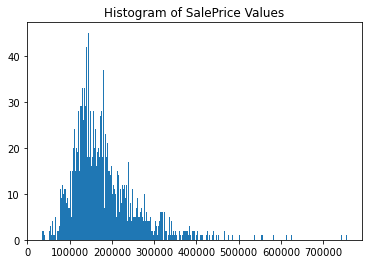

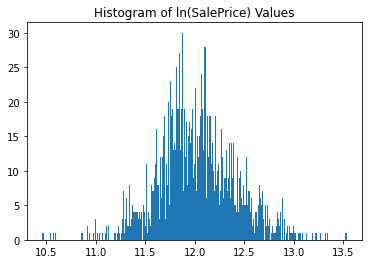

In [9]:
print('Dependent Variable Summary Statistics:\n{0}\n'.format(combined['SalePrice'].describe()))
print('Dependent Variable Median: {0}'.format(round(combined['SalePrice'].median(), 0)))
print('Dependent Variable Mean: {0}\n'.format(round(combined['SalePrice'].mean(), 0)))
print('Skew statistic : {0}'.format(skew(combined['SalePrice'])))

plt.hist(combined['SalePrice'], bins = 300)
plt.title("Histogram of SalePrice Values")
plt.show()

plt.hist(np.log(combined['SalePrice']), bins = 300)
plt.title("Histogram of ln(SalePrice) Values")
plt.show()

combined['SalePriceLn'] = np.log(combined['SalePrice'])

#### Independent Variables

Plot the histograms of numerical variables. There appears to be potential outliers with LotArea, MasVnrArea, BsmtFinSF1, BsmtFinSF2, TotalBsmtSF, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GarageYrBuilt, WoodDeckSF, OpenPorchSF, and EnclosedPorch which might be miscoded. Will examine these during Preprocessing.

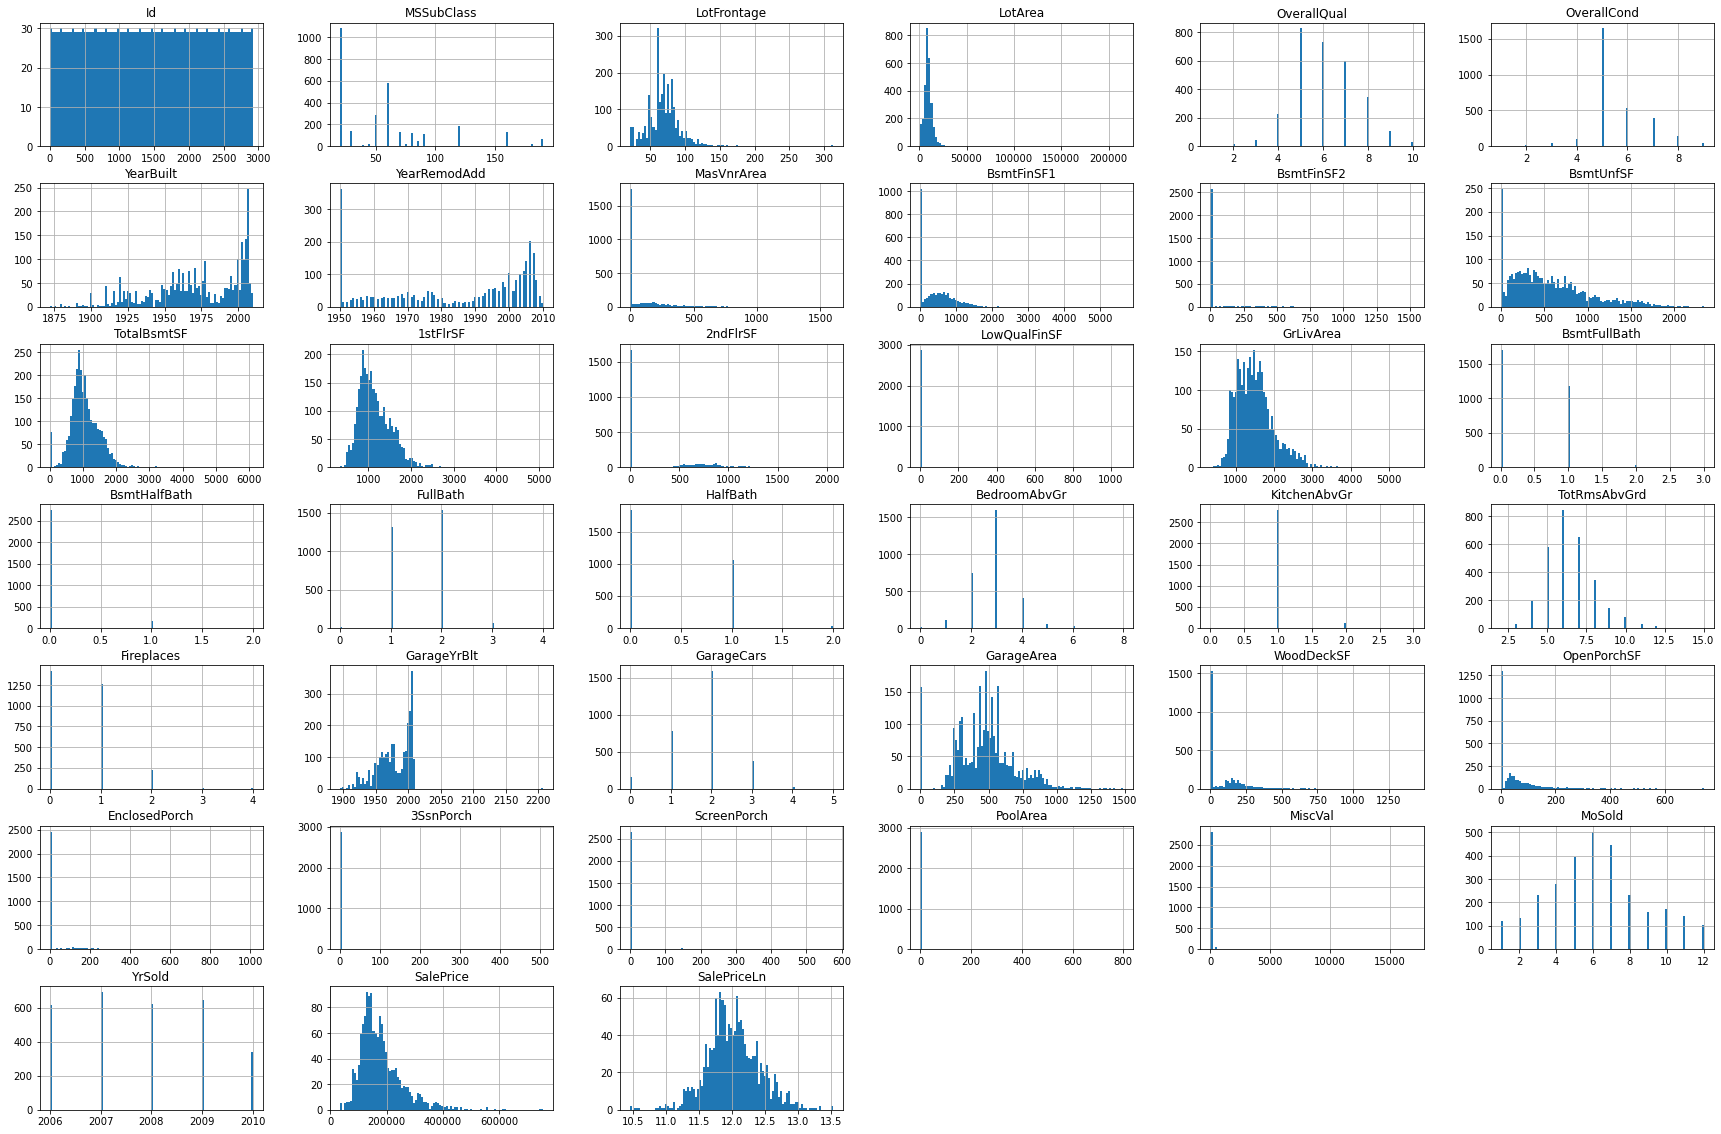

In [10]:
combined.hist(bins = 100, figsize = (30, 20))
plt.show()

Plot categorical variables

In [11]:
cat_vars = ['BsmtFullBath', 'BsmtHalfBath', 'MoSold', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'YrSold',
            'GarageCars', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Condition1', 'Neighborhood',
            'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 
            'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
            'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 
            'MiscFeature', 'SaleType', 'SaleCondition', 'GarageYrBlt', 'MSSubClass', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd']

##### Output

BsmtFullBath


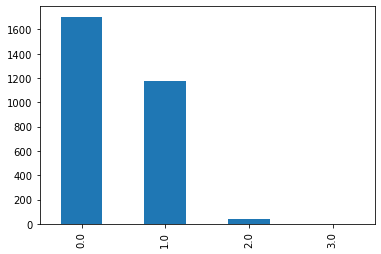

BsmtHalfBath


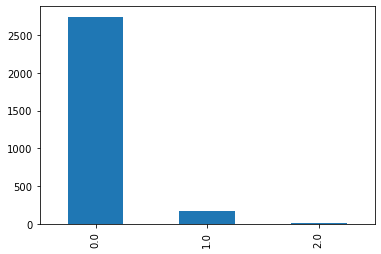

MoSold


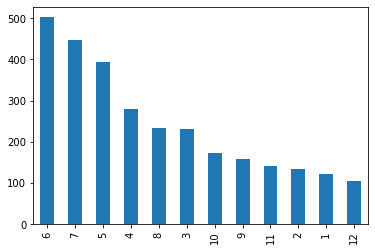

FullBath


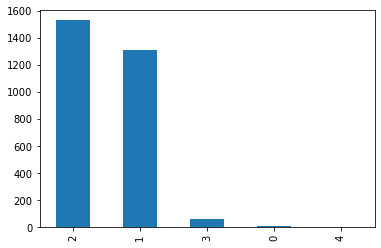

HalfBath


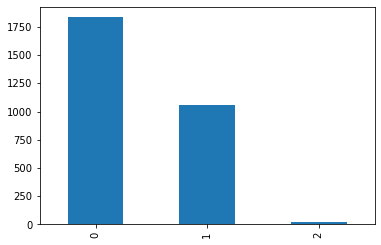

BedroomAbvGr


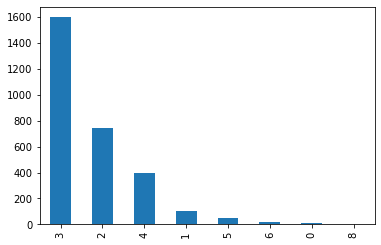

KitchenAbvGr


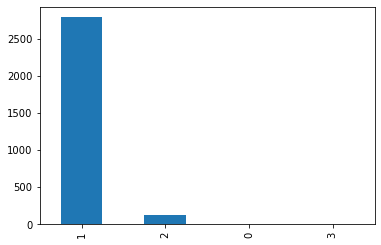

TotRmsAbvGrd


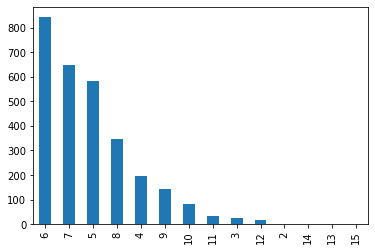

Fireplaces


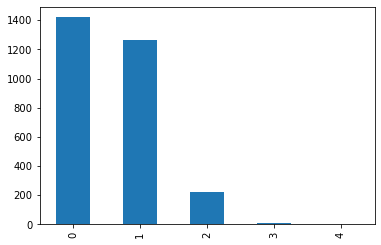

YrSold


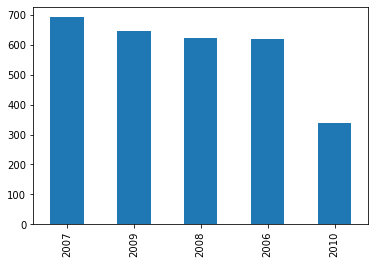

GarageCars


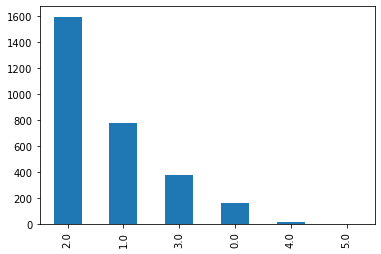

MSZoning


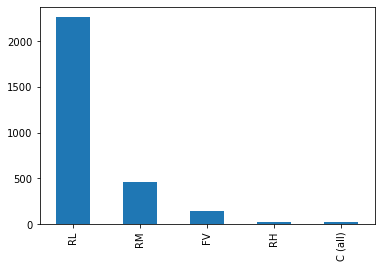

Street


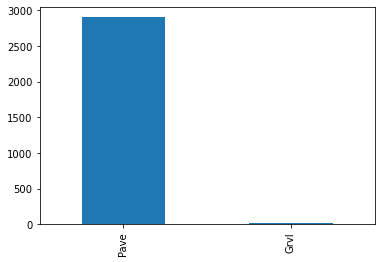

Alley


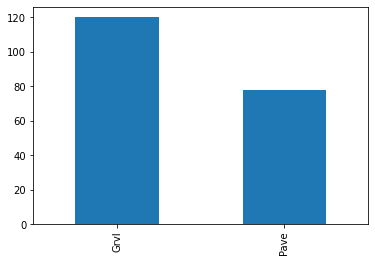

LotShape


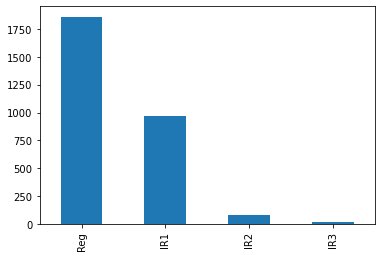

LandContour


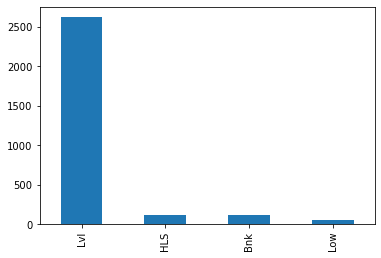

Utilities


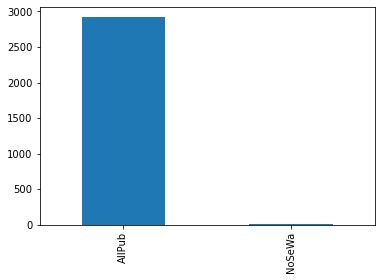

LotConfig


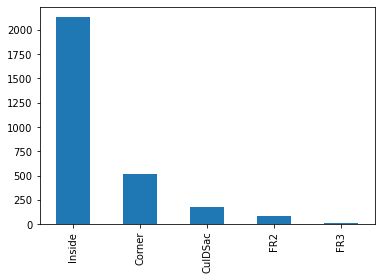

LandSlope


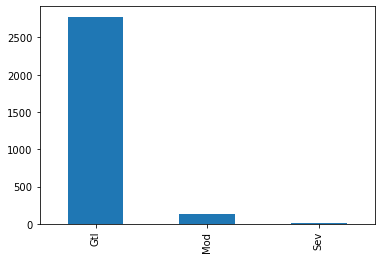

Condition1


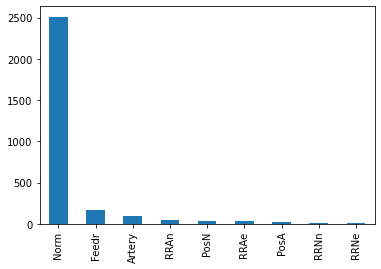

Neighborhood


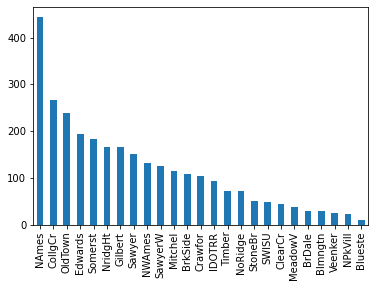

Condition2


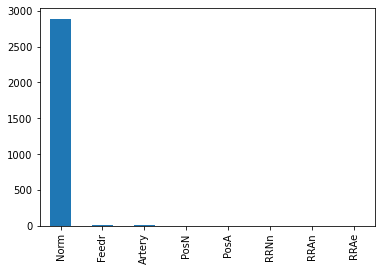

BldgType


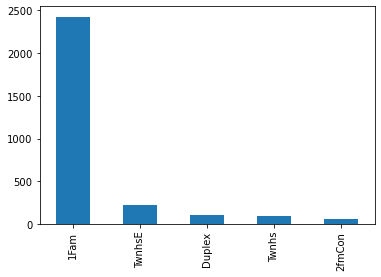

HouseStyle


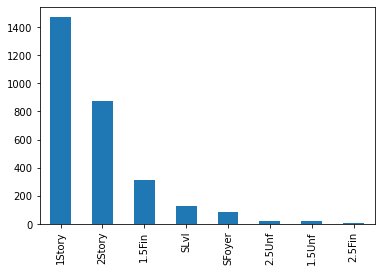

RoofStyle


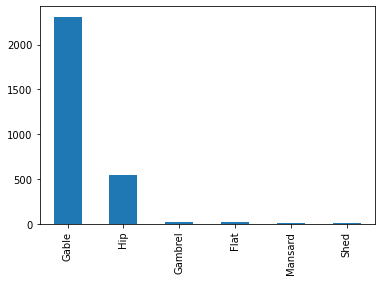

RoofMatl


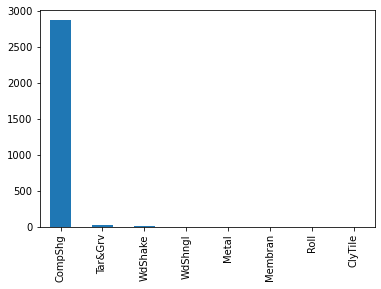

Exterior1st


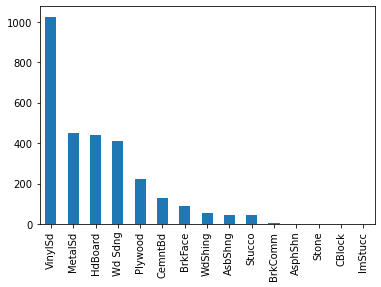

Exterior2nd


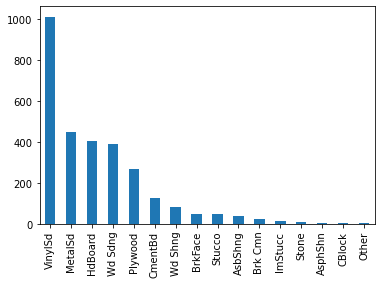

MasVnrType


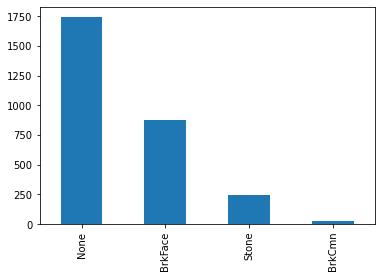

ExterQual


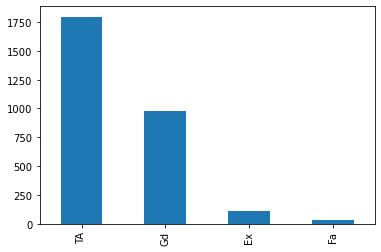

ExterCond


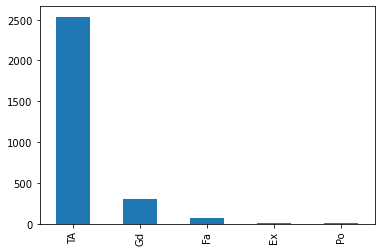

Foundation


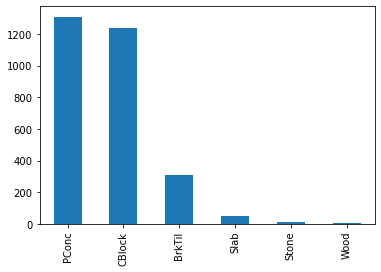

BsmtQual


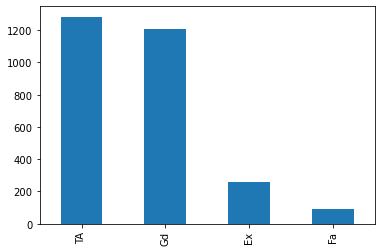

BsmtCond


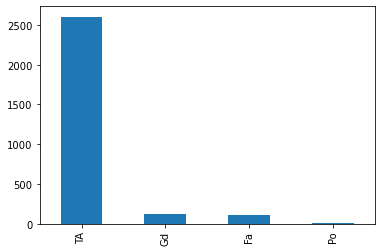

BsmtExposure


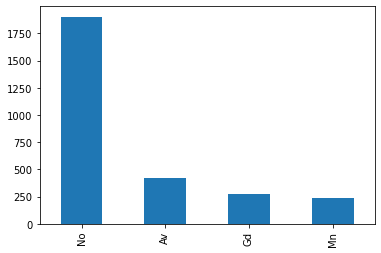

BsmtFinType1


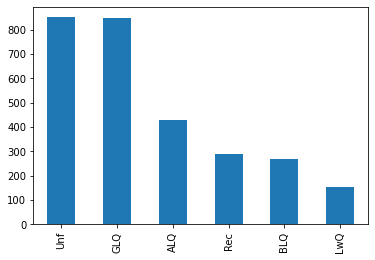

BsmtFinType2


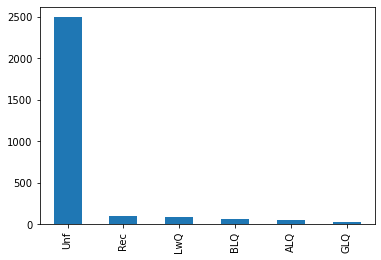

Heating


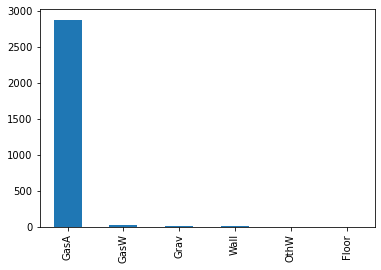

HeatingQC


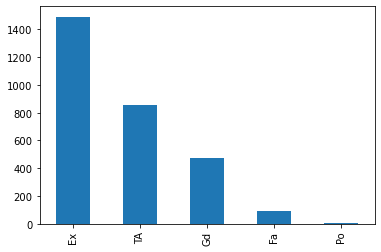

CentralAir


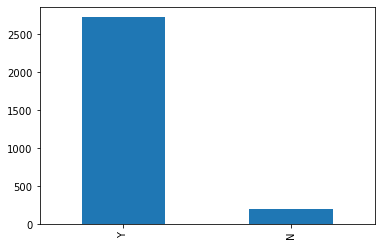

Electrical


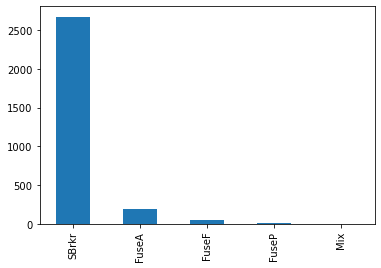

KitchenQual


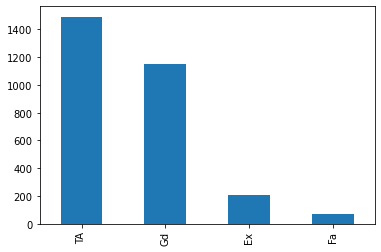

Functional


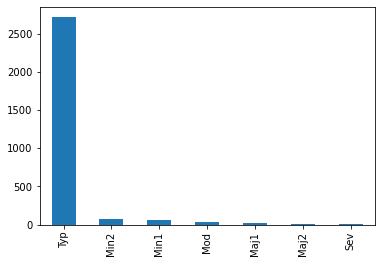

FireplaceQu


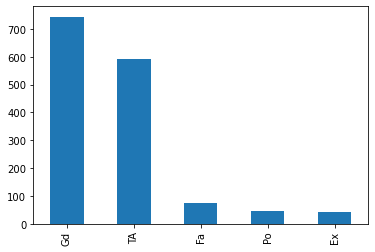

GarageType


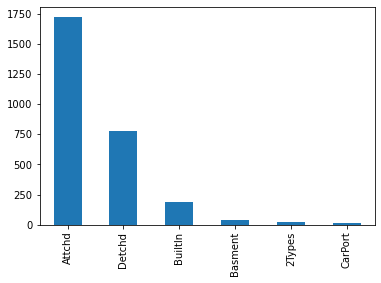

GarageFinish


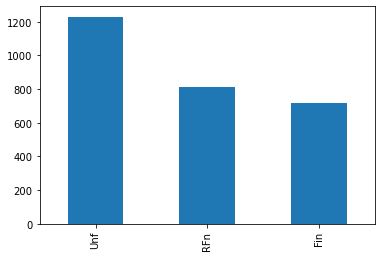

GarageQual


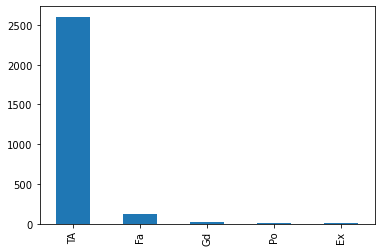

GarageCond


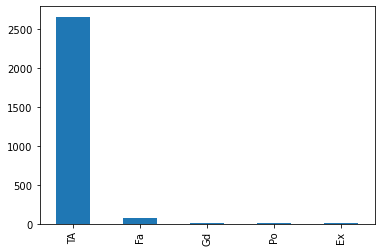

PavedDrive


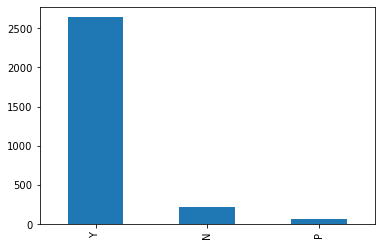

PoolQC


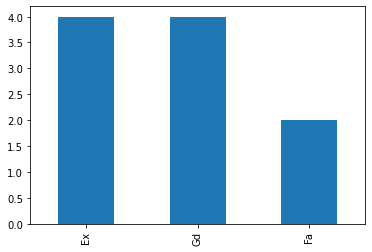

Fence


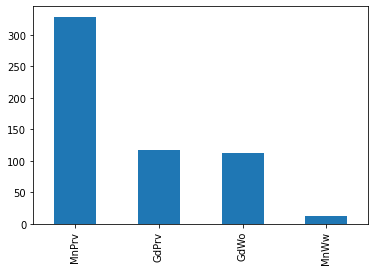

MiscFeature


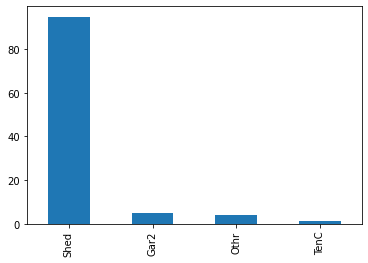

SaleType


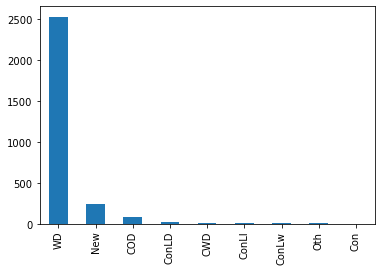

SaleCondition


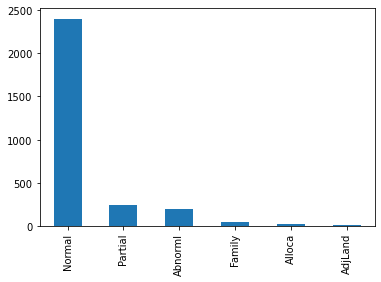

GarageYrBlt


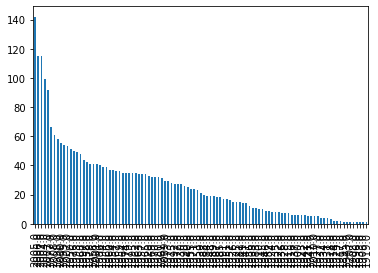

MSSubClass


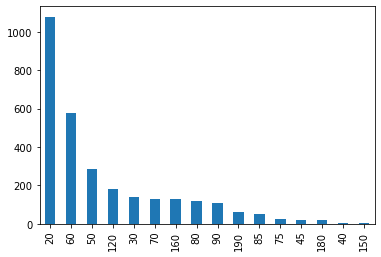

OverallQual


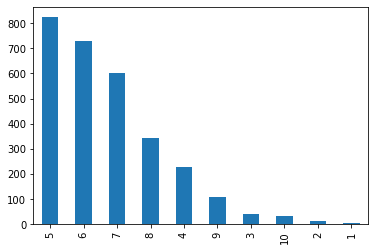

OverallCond


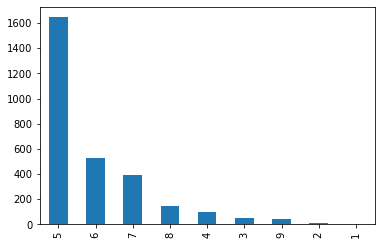

YearBuilt


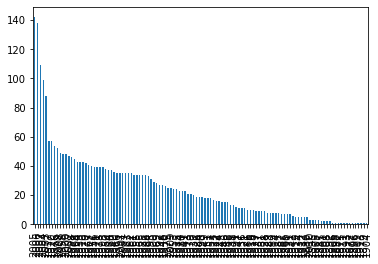

YearRemodAdd


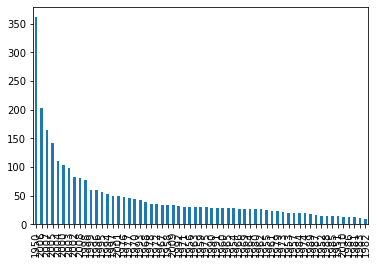

In [12]:
for i in cat_vars:
    print(i)
    combined[i].value_counts().plot.bar()
    plt.show()

### Relationship between SalePriceLn and Independent Variables

commentary 

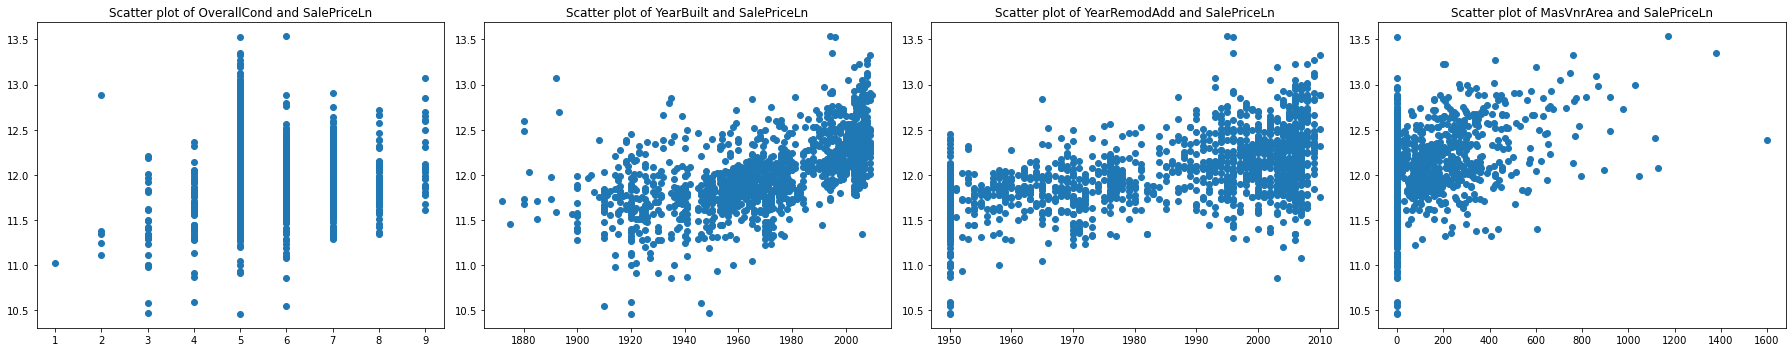

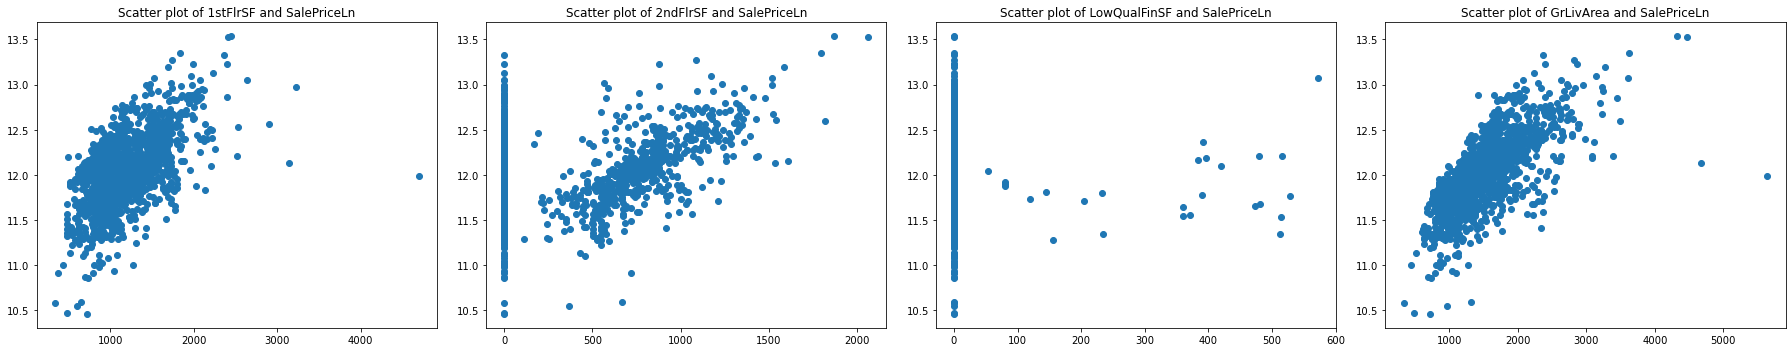

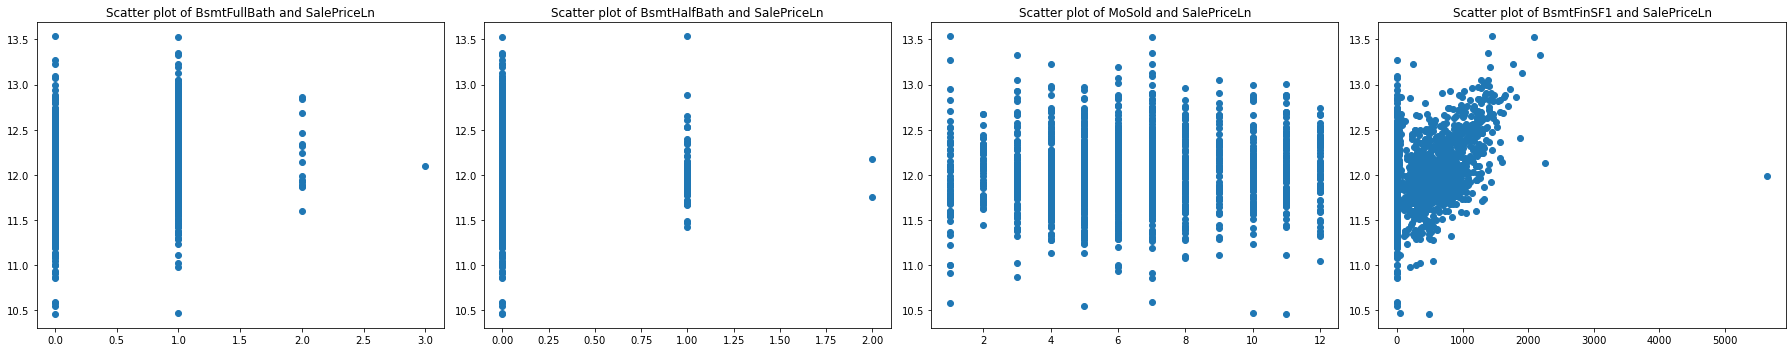

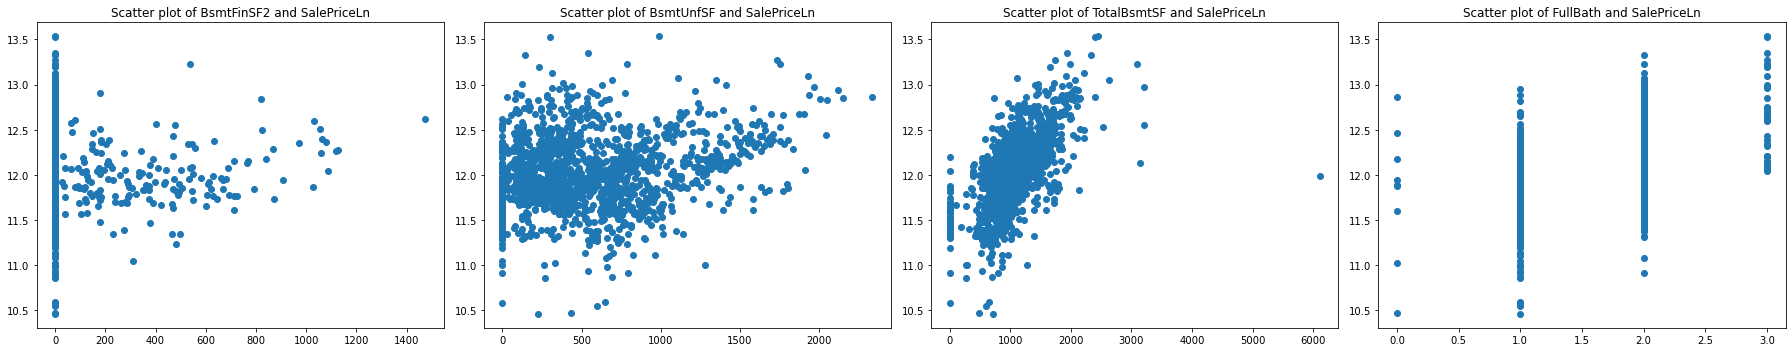

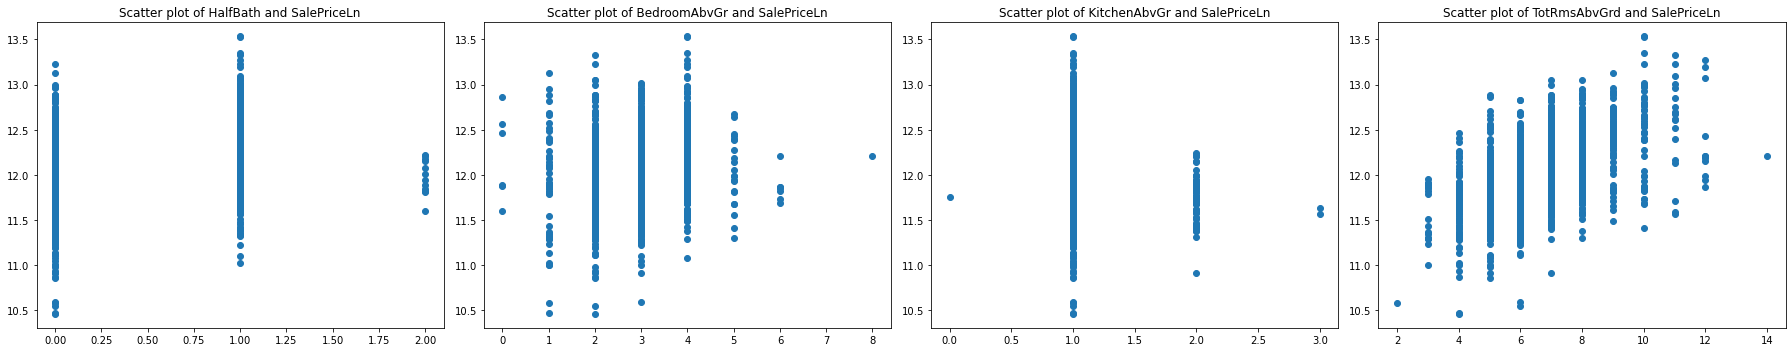

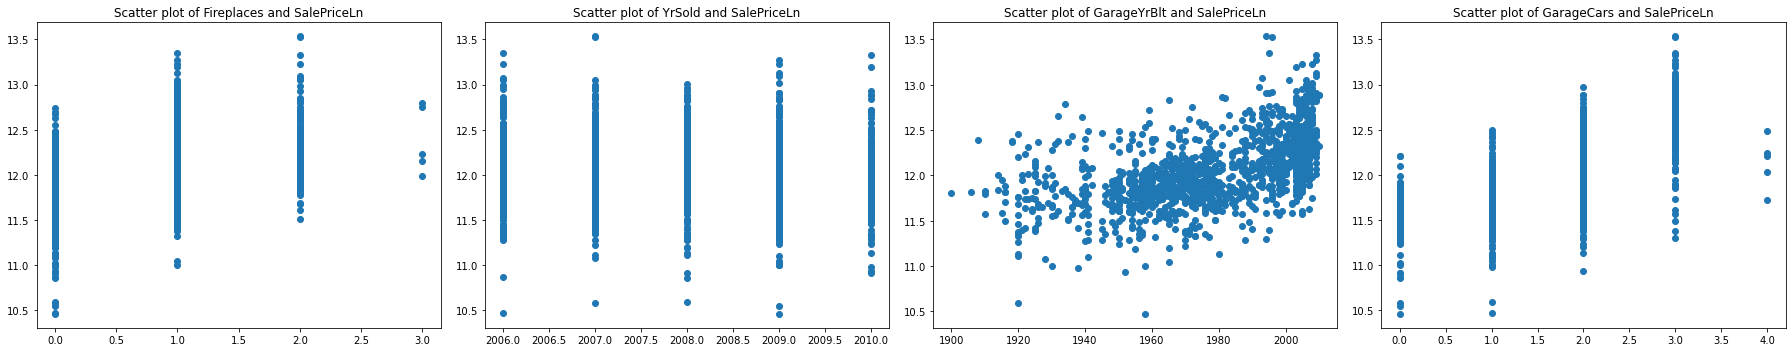

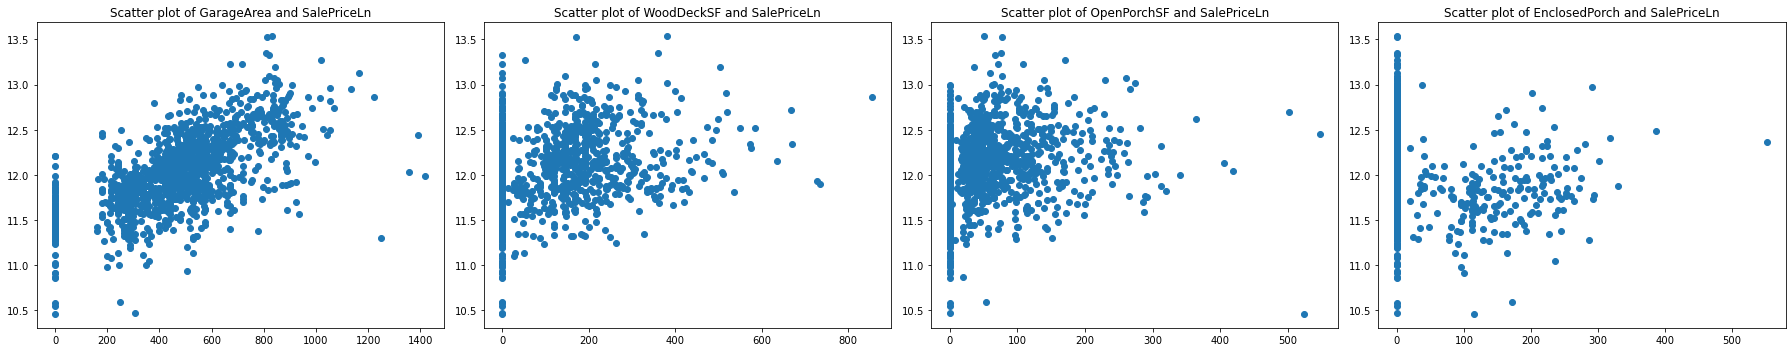

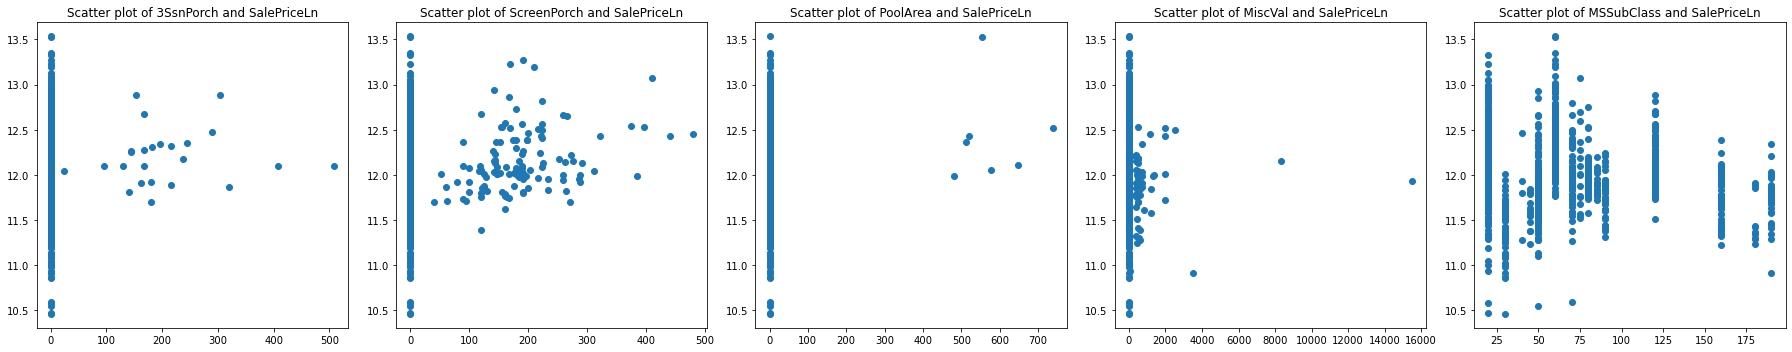

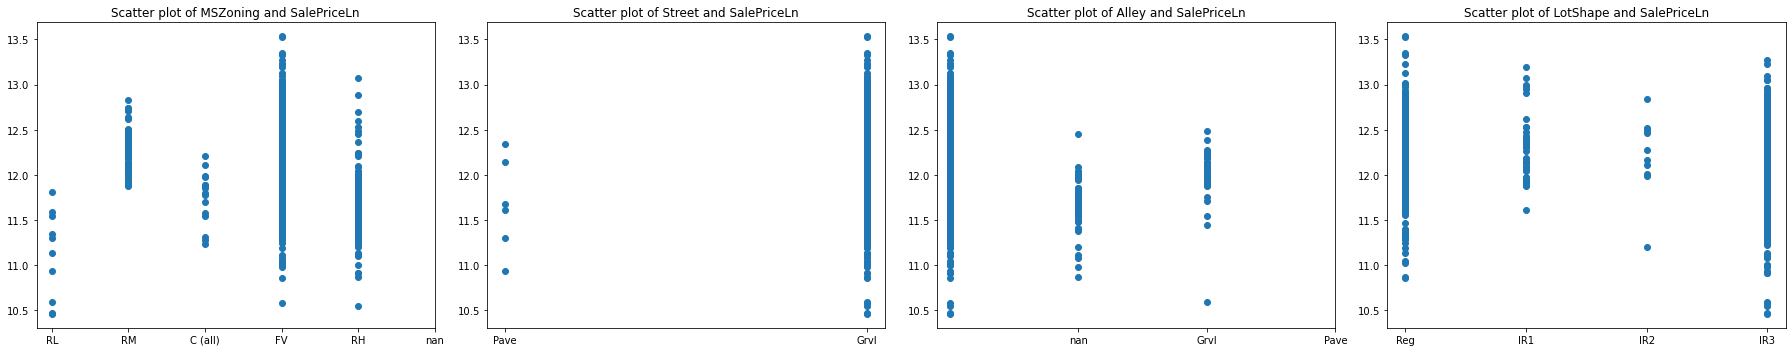

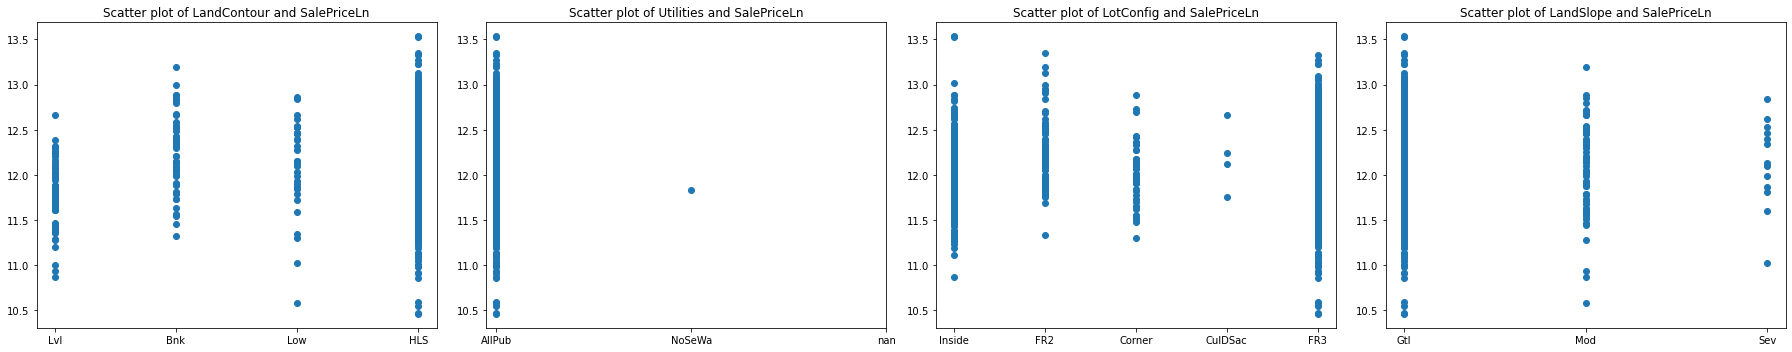

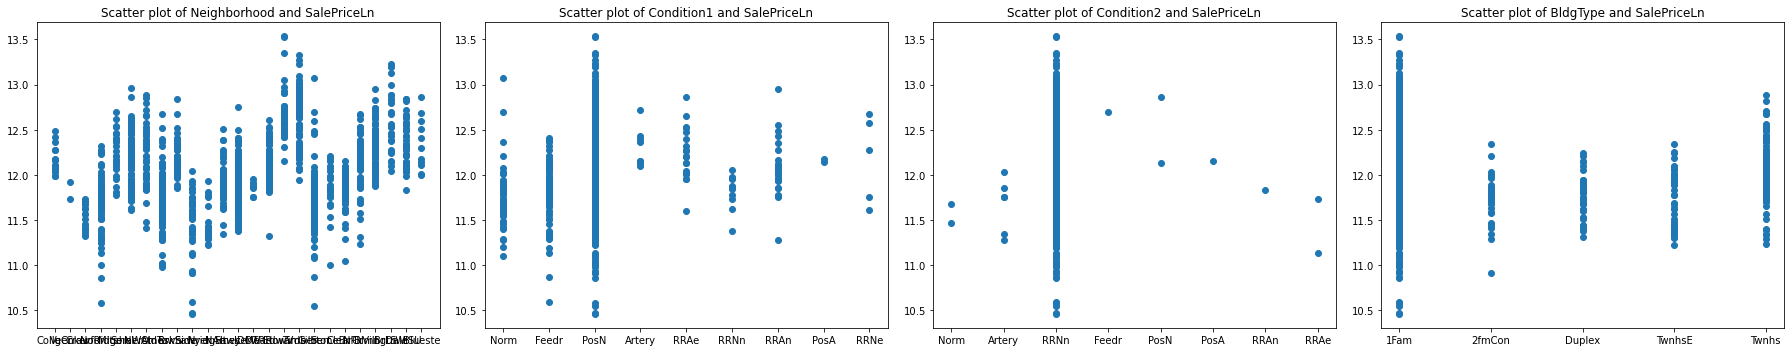

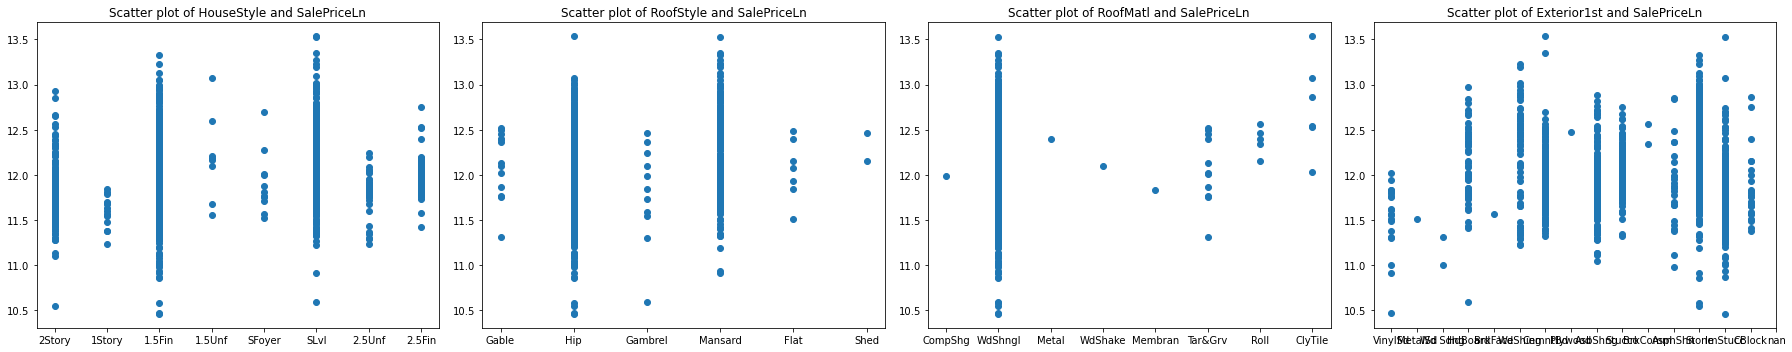

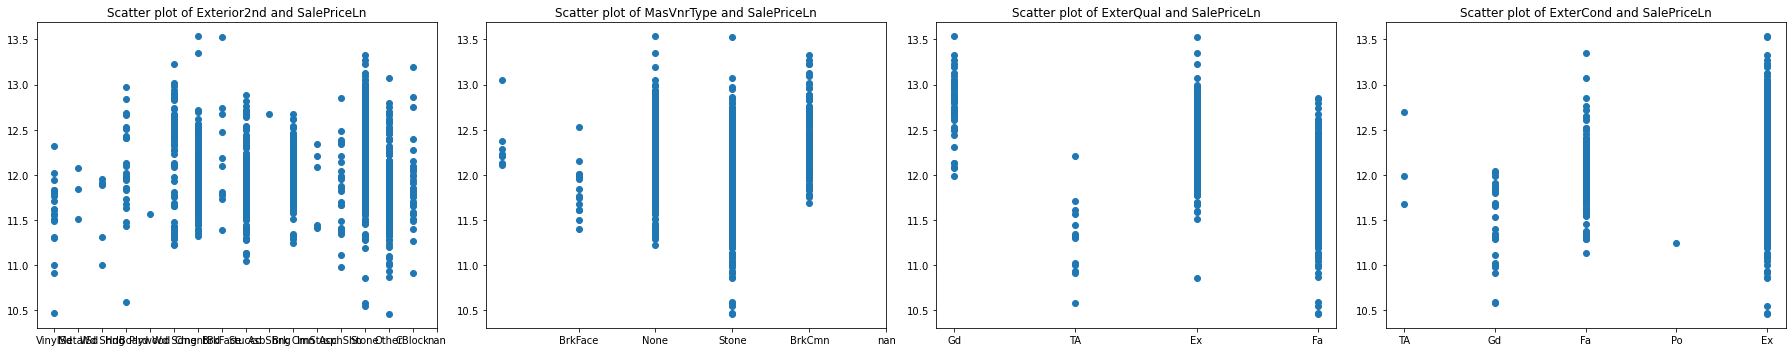

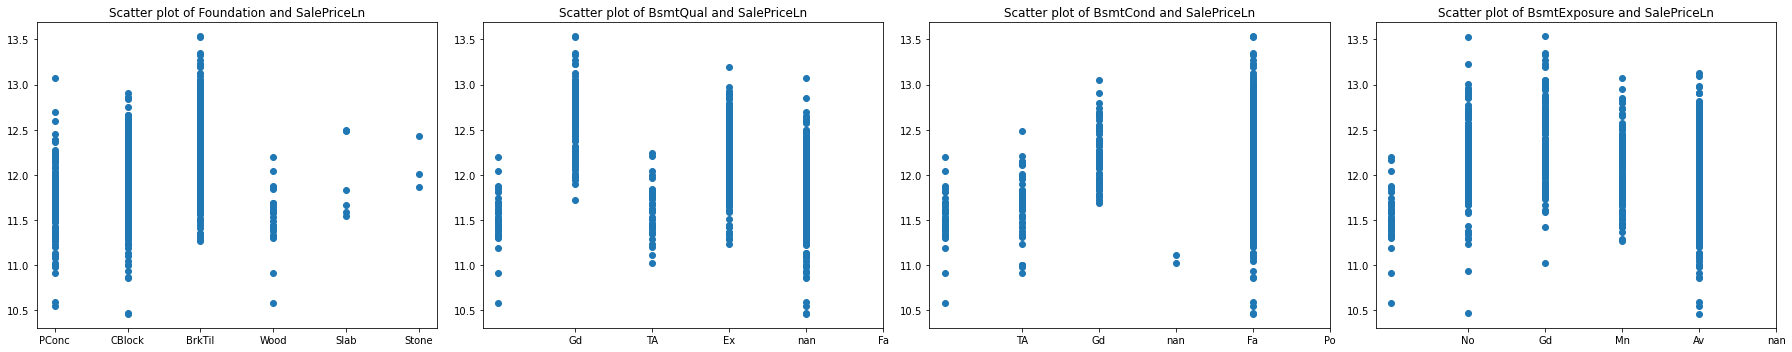

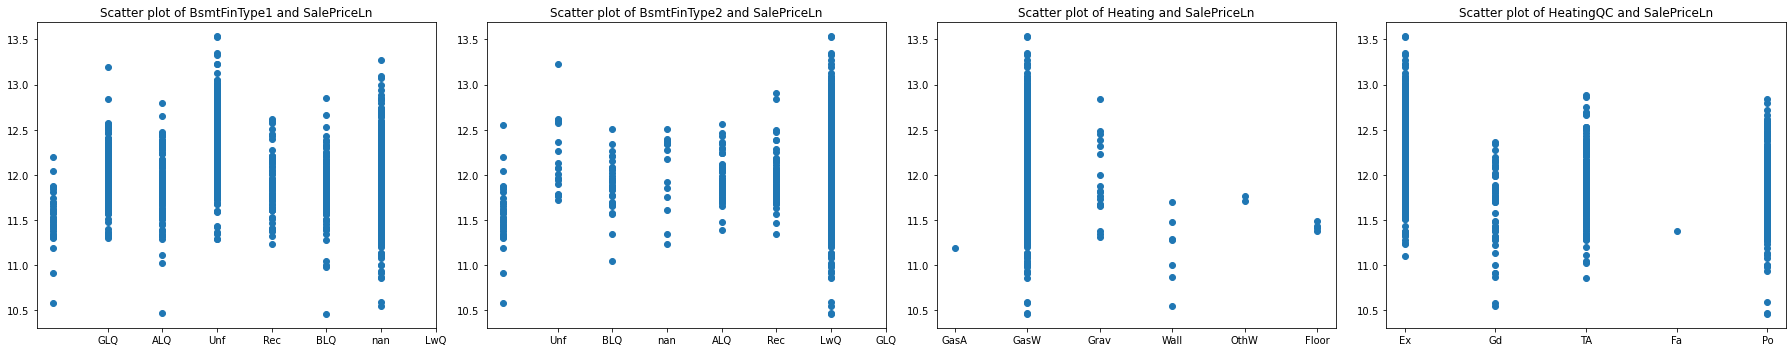

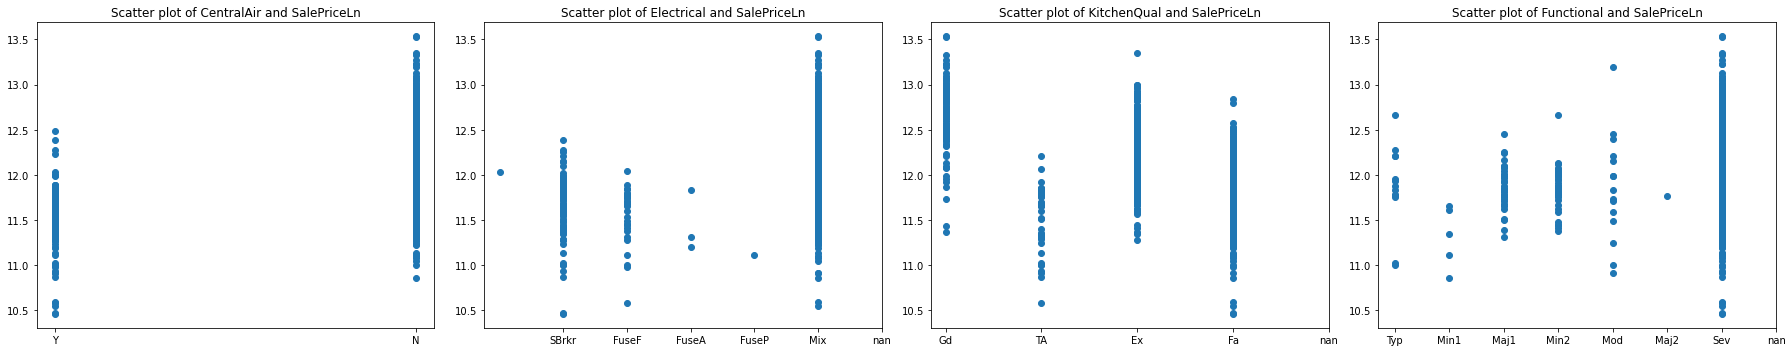

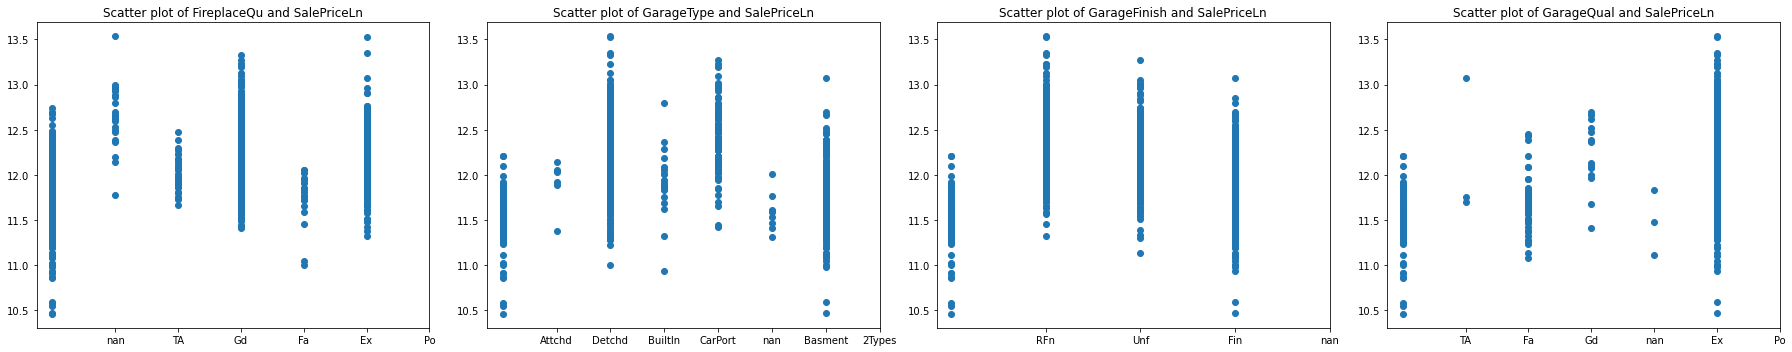

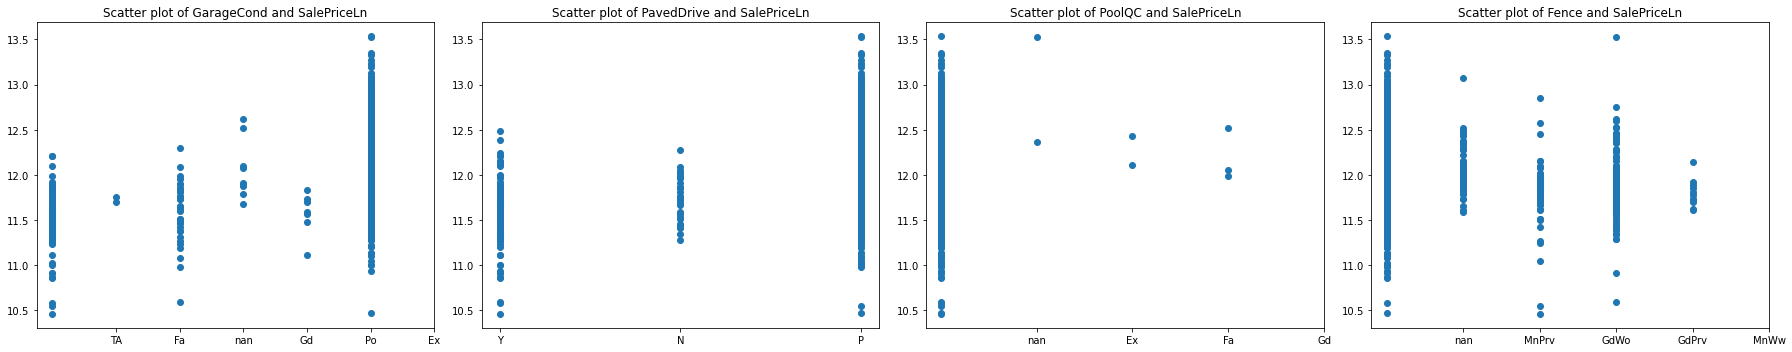

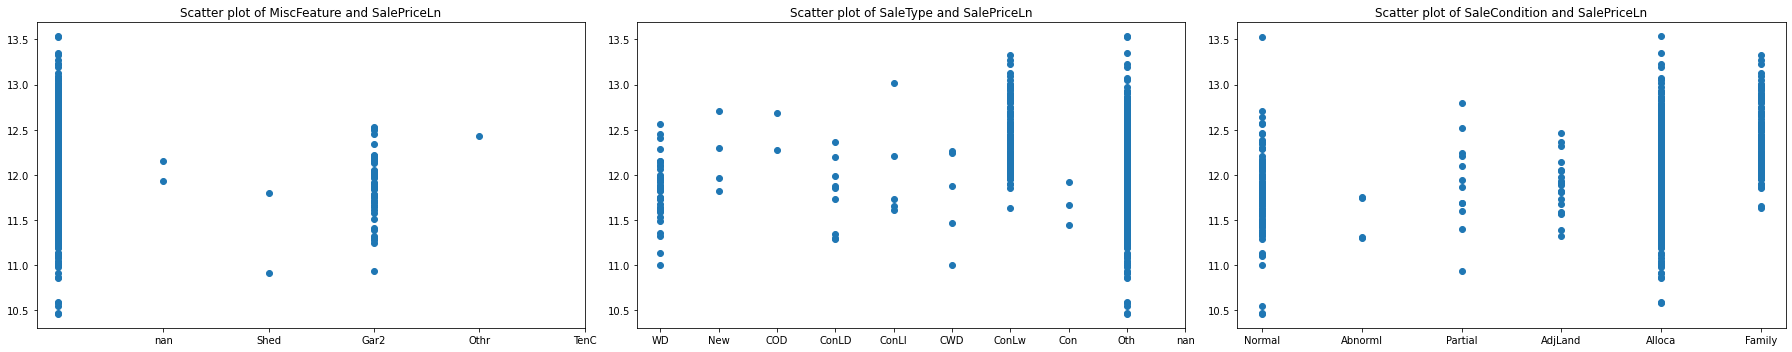

In [13]:
chart_gen('scatter', 0, 4, combined, ['OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea'], 'SalePriceLn')
chart_gen('scatter', 0, 4, combined, ['1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea'], 'SalePriceLn')
chart_gen('scatter', 0, 4, combined, ['BsmtFullBath', 'BsmtHalfBath', 'MoSold', 'BsmtFinSF1'], 'SalePriceLn')
chart_gen('scatter', 0, 4, combined, ['BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'FullBath'], 'SalePriceLn')
chart_gen('scatter', 0, 4, combined, ['HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd'], 'SalePriceLn')
chart_gen('scatter', 0, 4, combined, ['Fireplaces', 'YrSold', 'GarageYrBlt', 'GarageCars'], 'SalePriceLn')
chart_gen('scatter', 0, 4, combined, ['GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch'], 'SalePriceLn')
chart_gen('scatter', 0, 5, combined, ['3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MSSubClass'], 'SalePriceLn')
chart_gen('scatter-string', 0, 4, combined, ['MSZoning', 'Street', 'Alley', 'LotShape'], 'SalePriceLn')
chart_gen('scatter-string', 0, 4, combined, ['LandContour', 'Utilities', 'LotConfig', 'LandSlope'], 'SalePriceLn')
chart_gen('scatter-string', 0, 4, combined, ['Neighborhood', 'Condition1', 'Condition2', 'BldgType'], 'SalePriceLn')
chart_gen('scatter-string', 0, 4, combined, ['HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st'], 'SalePriceLn')
chart_gen('scatter-string', 0, 4, combined, ['Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond'], 'SalePriceLn')
chart_gen('scatter-string', 0, 4, combined, ['Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure'], 'SalePriceLn')
chart_gen('scatter-string', 0, 4, combined, ['BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC'], 'SalePriceLn')
chart_gen('scatter-string', 0, 4, combined, ['CentralAir', 'Electrical', 'KitchenQual', 'Functional'], 'SalePriceLn')
chart_gen('scatter-string', 0, 4, combined, ['FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual'], 'SalePriceLn')
chart_gen('scatter-string', 0, 4, combined, ['GarageCond', 'PavedDrive', 'PoolQC', 'Fence'], 'SalePriceLn')
chart_gen('scatter-string', 0, 3, combined, ['MiscFeature', 'SaleType', 'SaleCondition'], 'SalePriceLn')

### Missing Values

commentary

In [14]:
# Determine how many NAN values each observation has
combined['nan'] = 0
for i in range(0, len(combined)):
    combined.loc[i, 'nan'] = combined.loc[i, :].isnull().sum().sum()

print("Value Counts of the # of NaN's in an observation:")
print(combined['nan'].value_counts().sort_values(ascending=False))

Value Counts of the # of NaN's in an observation:
6     691
4     649
5     637
7     497
3     132
8      69
10     64
12     54
9      41
11     39
2      16
13     10
14      6
17      6
15      5
1       2
18      1
Name: nan, dtype: int64


In [15]:
# Obtain the name of the column and number of missing values

missing_values = pd.DataFrame(columns = ['Column Name', '# NaN'])

for i in range(0, len(combined.columns)):
    count = combined.iloc[:, i].isnull().sum()
    if count > 0:
        new_row = {'Column Name': combined.columns[i], '# NaN': count}
        missing_values = missing_values.append(new_row, ignore_index=True)

In [16]:
missing_values

Column Name # NaN
0       MSZoning     4
1    LotFrontage   486
2          Alley  2721
3      Utilities     2
4    Exterior1st     1
5    Exterior2nd     1
6     MasVnrType    24
7     MasVnrArea    23
8       BsmtQual    81
9       BsmtCond    82
10  BsmtExposure    82
11  BsmtFinType1    79
12    BsmtFinSF1     1
13  BsmtFinType2    80
14    BsmtFinSF2     1
15     BsmtUnfSF     1
16   TotalBsmtSF     1
17    Electrical     1
18  BsmtFullBath     2
19  BsmtHalfBath     2
20   KitchenQual     1
21    Functional     2
22   FireplaceQu  1420
23    GarageType   157
24   GarageYrBlt   159
25  GarageFinish   159
26    GarageCars     1
27    GarageArea     1
28    GarageQual   159
29    GarageCond   159
30        PoolQC  2909
31         Fence  2348
32   MiscFeature  2814
33      SaleType     1
34     SalePrice  1459
35   SalePriceLn  1459

## Preprocessing

The following steps first deal with missing data, then feature creation, dummy variables for categorical variables, and correlation heat maps to down-select features to include in the model.

#### Outliers

There appears to be potential outliers with LotArea, MasVnrArea, BsmtFinSF1, BsmtFinSF2, TotalBsmtSF, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GarageYrBuilt, WoodDeckSF, OpenPorchSF, and EnclosedPorch which might be miscoded.

I tackle outliers in the modeling stage by looking at studentized residuals, leverage, and Cook's Distance Method to determine the influence each observation has on the model.

In [17]:
outlier_vars = ['LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GarageYrBlt', 
                'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch']

for i in outlier_vars:
    print(i)
    print(combined[i].describe())

LotArea
count      2919.000000
mean      10168.114080
std        7886.996359
min        1300.000000
25%        7478.000000
50%        9453.000000
75%       11570.000000
max      215245.000000
Name: LotArea, dtype: float64
MasVnrArea
count    2896.000000
mean      102.201312
std       179.334253
min         0.000000
25%         0.000000
50%         0.000000
75%       164.000000
max      1600.000000
Name: MasVnrArea, dtype: float64
BsmtFinSF1
count    2918.000000
mean      441.423235
std       455.610826
min         0.000000
25%         0.000000
50%       368.500000
75%       733.000000
max      5644.000000
Name: BsmtFinSF1, dtype: float64
BsmtFinSF2
count    2918.000000
mean       49.582248
std       169.205611
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      1526.000000
Name: BsmtFinSF2, dtype: float64
TotalBsmtSF
count    2918.000000
mean     1051.777587
std       440.766258
min         0.000000
25%       793.000000
50%       989.500000
75% 

In [18]:
# Check if the basement outliers and other outlier groupings are the same group.

check = combined[(combined['LotArea'] == combined['LotArea'].max()) | (combined['MasVnrArea'] == combined['MasVnrArea'].max()) | 
                 (combined['BsmtFinSF1'] == combined['BsmtFinSF1'].max()) | (combined['BsmtFinSF2'] == combined['BsmtFinSF2'].max()) | 
                 (combined['TotalBsmtSF'] == combined['TotalBsmtSF'].max()) | (combined['1stFlrSF'] == combined['1stFlrSF'].max()) | 
                 (combined['2ndFlrSF'] == combined['2ndFlrSF'].max()) | (combined['LowQualFinSF'] == combined['LowQualFinSF'].max()) | 
                 (combined['GarageYrBlt'] == combined['GarageYrBlt'].max()) | (combined['WoodDeckSF'] == combined['WoodDeckSF'].max()) | 
                 (combined['OpenPorchSF'] == combined['OpenPorchSF'].max()) | (combined['EnclosedPorch'] == combined['EnclosedPorch'].max())]

The issue is that of the 11 observations exhibiting these outliers, only 4 of them are within the training set index, the other 7 are within the test set. 
Look at observation 297, its MasVnrArea is the max value. However, its not too far removed so I'll keep it for now. In the modeling stage I may drop it.
Looking at observation 313, it has a massive lot area. Considering the garage was was in 1965, it is feasible that this is a valid observation. However, its such an extreme outlier (especially considering its SalePrice) that I'll drop it. 
Looking at observation 1182, it has the max value for 2ndFlrSF. Its not too far removed so I'll keep it for now. In the modeling stage I may drop it.
Looking at observation 1298, it has the max BsmtFinSF1. Its an extreme outlier (especially considering its salePrice) so I'll drop it.

For the test observations, I don't see any observations where I can impute a clear miscoding except for 2592, GarageYrBlt. I'll change that to 2007.

In [19]:
check[['LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GarageYrBlt', 
      'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'SalePrice', 'OverallCond']]

LotArea  MasVnrArea  BsmtFinSF1  BsmtFinSF2  TotalBsmtSF  1stFlrSF  \
297      7399      1600.0       649.0         0.0        975.0       975   
313    215245         0.0      1236.0       820.0       2136.0      2036   
1182    15623         0.0      2096.0         0.0       2396.0      2411   
1298    63887       796.0      5644.0         0.0       6110.0      4692   
1698    10750       634.0       236.0      1526.0       2024.0      2063   
1785    10410         0.0         0.0         0.0       1313.0      1313   
2503    23920         0.0         0.0         0.0       1105.0      1105   
2549    39290      1224.0      4010.0         0.0       5095.0      5095   
2557    10890         0.0       371.0         0.0       1296.0      1296   
2592     8298         NaN       583.0         0.0       1546.0      1564   
2606    15957         0.0      1148.0         0.0       1244.0      1356   

      2ndFlrSF  LowQualFinSF  GarageYrBlt  WoodDeckSF  OpenPorchSF  \
297        975             0       1997.0           0           10   
313          0             0       1965.0           0            0   
1182      2065             0       1996.0         171           78   
1298       950             0       2008.0         214          292   
1698         0             0       1994.0         182           56   
1785         0          1064       1954.0           0            0   
2503       717             0       1984.0           0          195   
2549         0             0       2008.0         546          484   
2557      1296             0          NaN           0          742   
2592         0             0       2207.0         132            0   
2606         0             0       1977.0        1424            0   

      EnclosedPorch  SalePrice  OverallCond  
297               0   239000.0            5  
313               0   375000.0            5  
1182              0   745000.0            5  
1298              0   160000.0            5  
1698              0        NaN            5  
1785            432        NaN            5  
2503           1012        NaN            5  
2549              0        NaN            5  
2557            240        NaN            6  
2592              0        NaN            5  
2606              0        NaN            6

In [20]:
combined.loc[combined['GarageYrBlt'] == 2207, 'GarageYrBlt'] = 2007
combined_dropped = combined.drop(index=[313, 1298])

#### Missing Data

##### Variables: Fence, MiscFeature, PoolQC, FireplaceQu, and Alley

I tackle Fence, MiscFeature, PoolQC, FireplaceQu, Alley in a grouping since these five consist of the most missing values by a wide margin and all their NaNs should be recoded as "None"

In [21]:
for i in ['Fence', 'MiscFeature', 'PoolQC', 'FireplaceQu', 'Alley']:
    combined_dropped[i] = combined_dropped[i].fillna('None')

##### Variables: GarageType, GarageYrBlt, GarageFinish, GarageQual, GarageCond, GarageCars, GarageArea

I tackle garage related variables in a single grouping. Looking at data_description.txt, all their NaNs should be recoded as "None" to represent the property not having a garage.

In [22]:
for i in ['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']:
    combined_dropped[i] = combined_dropped[i].fillna('None')

I examine the observations that are missing GarageCars and GarageArea

In [23]:
garage_check = combined_dropped[(pd.isna(combined_dropped['GarageCars'])) | (pd.isna(combined_dropped['GarageArea']))]

Since this observation only has one garage variable that has a valid value (all others were recorded as NA) I assume that listing the garage as detached was a mistake and should be None as well.

In [24]:
garage_check[['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'GarageCars', 'GarageArea']]

GarageType GarageYrBlt GarageFinish GarageQual GarageCond  GarageCars  \
2576     Detchd        None         None       None       None         NaN   

      GarageArea  
2576         NaN

In [25]:
combined_dropped.loc[2576, 'GarageType'] = 'None'
combined_dropped.loc[2576, 'GarageCars'] = 0
combined_dropped.loc[2576, 'GarageArea'] = 0

##### Variables: BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF

I tackle basement related variables in a single grouping. Looking at data_description.txt, most of these observations NaNs should be recoded as "None" to represent the property not having a basement.

I first tackle TotalBsmtSF. There is only one missing value and Once I have solved that, I can determine if the other basement observations should have values or not. I use the most common value for that variable as the imputation

In [26]:
check_totsf = combined_dropped[pd.isna(combined_dropped['TotalBsmtSF']) == True]

Since all basement values are NA, I'll assume this house doesn't have a basement.

In [27]:
check_totsf[['TotalBsmtSF', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF']]

TotalBsmtSF BsmtQual BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1  \
2120          NaN      NaN      NaN          NaN          NaN         NaN   

     BsmtFinType2  BsmtFinSF2  BsmtUnfSF  
2120          NaN         NaN        NaN

In [28]:
combined_dropped.loc[pd.isna(combined_dropped['TotalBsmtSF']) == True, 'TotalBsmtSF'] = 0

In [29]:
combined_dropped.loc[(combined_dropped['TotalBsmtSF'] == 0) & (pd.isna(combined_dropped['BsmtQual']) == True), 'BsmtQual'] = 'None'
combined_dropped.loc[(combined_dropped['TotalBsmtSF'] > 0) & (pd.isna(combined_dropped['BsmtQual']) == True), 'BsmtQual'] = 'TA'

In [30]:
combined_dropped.loc[(combined_dropped['TotalBsmtSF'] == 0) & (pd.isna(combined_dropped['BsmtCond']) == True), 'BsmtCond'] = 'None'
combined_dropped.loc[(combined_dropped['TotalBsmtSF'] > 0) & (pd.isna(combined_dropped['BsmtCond']) == True), 'BsmtCond'] = 'TA'

In [31]:
combined_dropped.loc[(combined_dropped['TotalBsmtSF'] == 0) & (pd.isna(combined_dropped['BsmtExposure']) == True), 'BsmtExposure'] = 'None'
combined_dropped.loc[(combined_dropped['TotalBsmtSF'] > 0) & (pd.isna(combined_dropped['BsmtExposure']) == True), 'BsmtExposure'] = 'No'

In [32]:
combined_dropped.loc[(combined_dropped['TotalBsmtSF'] == 0) & (pd.isna(combined_dropped['BsmtFinType1']) == True), 'BsmtFinType1'] = 'None'
combined_dropped.loc[(combined_dropped['TotalBsmtSF'] > 0) & (pd.isna(combined_dropped['BsmtFinType1']) == True), 'BsmtFinType1'] = 'Unf'

In [33]:
combined_dropped.loc[(combined_dropped['TotalBsmtSF'] == 0) & (pd.isna(combined_dropped['BsmtFinSF1']) == True), 'BsmtFinSF1'] = 0
combined_dropped.loc[(combined_dropped['TotalBsmtSF'] > 0) & (pd.isna(combined_dropped['BsmtFinSF1']) == True), 'BsmtFinSF1'] = combined_dropped['TotalBsmtSF'].median()

In [34]:
combined_dropped.loc[(combined_dropped['TotalBsmtSF'] == 0) & (pd.isna(combined_dropped['BsmtFinType2']) == True), 'BsmtFinType2'] = 'None'
combined_dropped.loc[(combined_dropped['TotalBsmtSF'] > 0) & (pd.isna(combined_dropped['BsmtFinType2']) == True), 'BsmtFinType2'] = 'Unf'

In [35]:
combined_dropped.loc[pd.isna(combined_dropped['BsmtFinSF2']) == True, 'BsmtFinSF2'] = 0

In [36]:
combined_dropped.loc[pd.isna(combined_dropped['BsmtUnfSF']) == True, 'BsmtUnfSF'] = 0

##### Variable: Electrical

There is only one missing observation so I insert the most common value, in this case SBrkr which is found in 91.2% of all homes in the data set.

In [37]:
combined_dropped['Electrical'].value_counts()

SBrkr    2669
FuseA     188
FuseF      50
FuseP       8
Mix         1
Name: Electrical, dtype: int64

In [38]:
combined_dropped.loc[pd.isna(combined_dropped['Electrical']) == True, 'Electrical'] = 'SBrkr'

##### Variables: MasVnrType and MasVnrArea

To impute the values for MasVnrType and MasVnrArea, I use the median value, which in this case is no masonry and thus 0 area.

In [39]:
print(combined_dropped['MasVnrType'].value_counts())
print(combined_dropped['MasVnrArea'].value_counts())

combined_dropped.loc[pd.isna(combined_dropped['MasVnrType']) == True, 'MasVnrType'] = 'None'
combined_dropped.loc[pd.isna(combined_dropped['MasVnrArea']) == True, 'MasVnrArea'] = 0.0

None       1741
BrkFace     879
Stone       248
BrkCmn       25
Name: MasVnrType, dtype: int64
0.0      1737
120.0      15
176.0      13
200.0      13
180.0      12
         ... 
788.0       1
391.0       1
604.0       1
428.0       1
382.0       1
Name: MasVnrArea, Length: 443, dtype: int64


##### Variable: LotFrontage

Since there are other Lot variables, such as LotArea, LotShape, and LotConfig, I drop LotFrontage. The assumption is that these three variables will share some of the same explanation to the dependent variable variance as LotFrontage. Additionally, with 400+ missing values, the imputation would have low accuracy.

In [40]:
combined_dropped.drop(columns = ['LotFrontage'], axis = 1, inplace = True)

##### Variables: MSZoning, Utilites, Exterior1st, Exterior2nd, BsmtFullBath, BsmtHalfBath, KitchenQual, Functiona, SaleType

For these variables, since there are less than 5 missing in each column, I just use the most common value

In [41]:
combined_dropped.loc[pd.isna(combined_dropped['MSZoning']) == True, 'MSZoning'] = 'RL'
combined_dropped.loc[pd.isna(combined_dropped['Utilities']) == True, 'Utilities'] = 'AllPub'
combined_dropped.loc[pd.isna(combined_dropped['Exterior1st']) == True, 'Exterior1st'] = 'VinylSd'
combined_dropped.loc[pd.isna(combined_dropped['Exterior2nd']) == True, 'Exterior2nd'] = 'VinylSd'
combined_dropped.loc[pd.isna(combined_dropped['BsmtFullBath']) == True, 'BsmtFullBath'] = 0.0
combined_dropped.loc[pd.isna(combined_dropped['BsmtHalfBath']) == True, 'BsmtHalfBath'] = 0.0
combined_dropped.loc[pd.isna(combined_dropped['KitchenQual']) == True, 'KitchenQual'] = 'TA'
combined_dropped.loc[pd.isna(combined_dropped['Functional']) == True, 'Functional'] = 'Typ'
combined_dropped.loc[pd.isna(combined_dropped['SaleType']) == True, 'SaleType'] = 'WD'

#### New Features

Currently there are four variables encompassing all of the bathroom information. I create a single feature that captures all the bathrooms in a house. Most home buyers think of 2.5 baths not 2 full baths and 1 half bath. We can see that the new single variable ("Baths") is .08 more correlated to SalePriceLn than the previous highest bathroom variable of the four. 

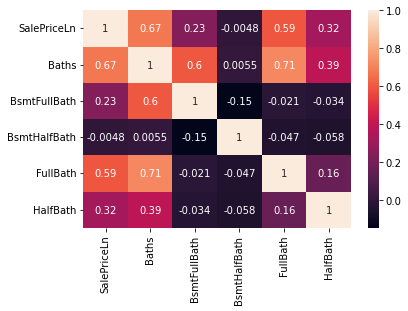

In [42]:
combined_dropped['Baths'] = combined_dropped['BsmtFullBath'] + combined_dropped['BsmtHalfBath']*.5 + combined_dropped['FullBath'] + combined_dropped['HalfBath']*.5

sn.heatmap(combined_dropped[['SalePriceLn', 'Baths', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath']].corr(), annot=True)
plt.show()


Currently there are three variables encompassing all of the square footage information. I create a single feature that captures all the square footage in a house plus garage. Most buyers look at aggregate square footage, not the individual square footage of the basement versus the area above grade (i.e. first floor and second floor). We can see that the new single variable ("TotSF") is .12 more correlated to SalePriceLn than the previous highest square footage variable of the three.

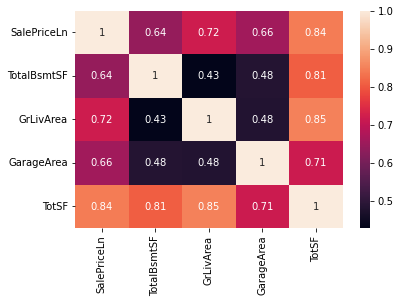

In [43]:
combined_dropped['TotSF'] = combined_dropped['TotalBsmtSF'] + combined_dropped['GrLivArea'] + combined_dropped['GarageArea']

sn.heatmap(combined_dropped[['SalePriceLn', 'TotalBsmtSF', 'GrLivArea', 'GarageArea', 'TotSF']].corr(), annot=True)
plt.show()

Currently there are six variables encompassing all of the square footage information for outdoor porches and decks. I create a single feature that captures all the square footage for decks/porches. Most buyers look at aggregate square footage, not the individual square footage. We can see that the new single variable ("OutdoorSF") is .06 more correlated to SalePriceLn than the previous highest square footage variable of the six.

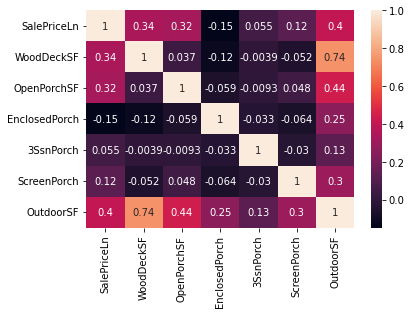

In [44]:
combined_dropped['OutdoorSF'] = combined_dropped['WoodDeckSF'] + combined_dropped['OpenPorchSF'] + combined_dropped['EnclosedPorch'] + combined_dropped['3SsnPorch'] + combined_dropped['ScreenPorch']

sn.heatmap(combined_dropped[['SalePriceLn', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'OutdoorSF']].corr(), annot=True)
plt.show()

Looking through the data documentation, I found that the value for the year remodel is the same year if the house was built. Thus, this variable isn't a clear indicator if the house has been remodeled. I thus create a 1/0 dummy variable if the house has been remodeled. However, it does not that this new variable has any explanatory power for SalePriceLn is likely to not be included in my models.

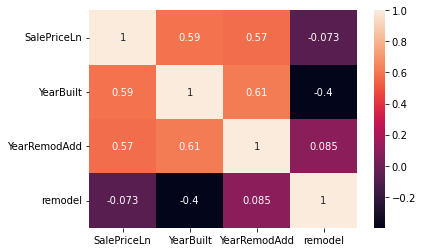

In [45]:
combined_dropped['remodel'] = combined_dropped['YearRemodAdd'] - combined_dropped['YearBuilt']
combined_dropped.loc[combined_dropped['remodel'] != 0, 'remodel'] = 1

sn.heatmap(combined_dropped[['SalePriceLn', 'YearBuilt', 'YearRemodAdd', 'remodel']].corr(), annot=True)
plt.show()

#### Categorical Variables

The data set has independent variables that are categorical. We handle these by creating dummy variables (1/0) for each potential value a independent variable could take on. Later in the down selection of variables, I ensure to leave one option out to avoid collinearity. This means the interpretation of the coefficients of these dummy variables is the difference from the left-out option. 

In [46]:
combined_encoded = pd.get_dummies(data = combined_dropped, columns = cat_vars)

#### Correlation Heat Maps

I generate a large correlation mapping to see which variables seem to be likely predictors of SalePrice while keeping an eye on collinearity. 

Examining the heatmap results showing correlations between our independent variables and dependent variable (SalePrice), only a couple variables jump out as strong predictors of price (in either direction). OverallQual, YearBuilt, YearRemodAdd, TotSF, and Baths. All of these have a correlation of absolute value of .5 or higher. 

We see some interesting results when we look at the dummy variables that were generated from categorical variabes. We see that having a single full bath above grade is penalized while having two or more full baths is rewarded. We additionally see this starkly with the # of cars in a garage. 1 space is penalized, 2 spaces is assumed (correlation is almost 0) and 3 spaces has a correlation of .61. Looking at Fireplaces, housing styles, roof style, exterior, central air, heating, kitchen quality, garage type, garage finish, sale type, and garage year built we see similar patterns where having a certain type of feature is rewarded, others are penalized, and some types have no impact on price. 

##### Heat map results

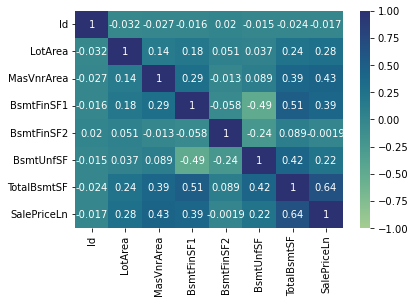

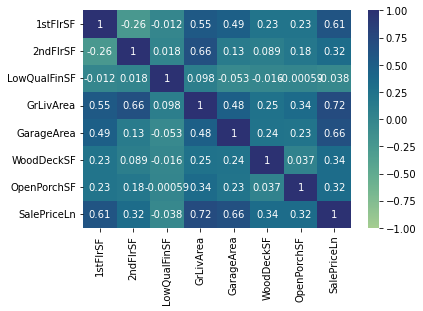

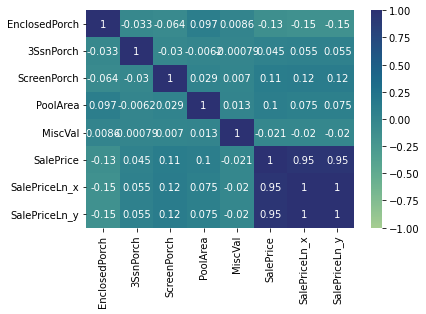

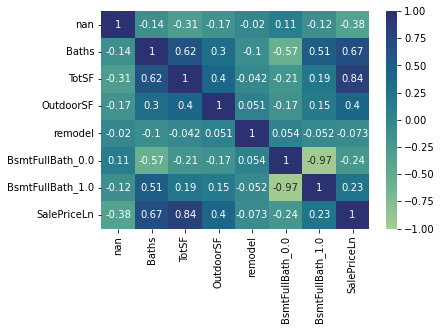

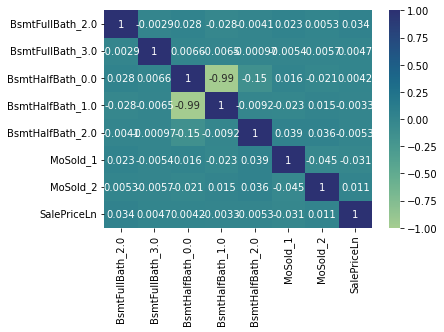

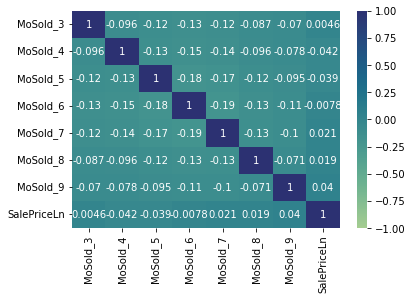

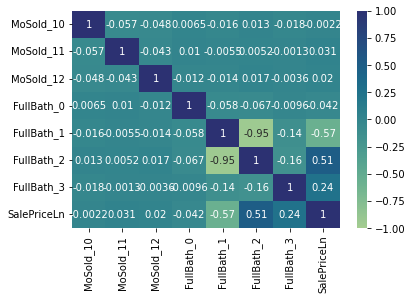

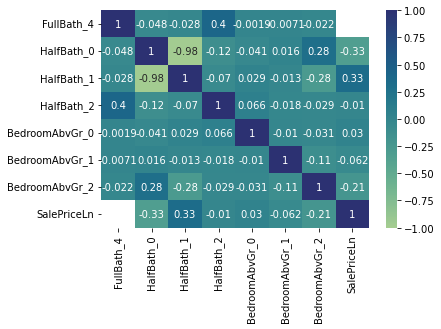

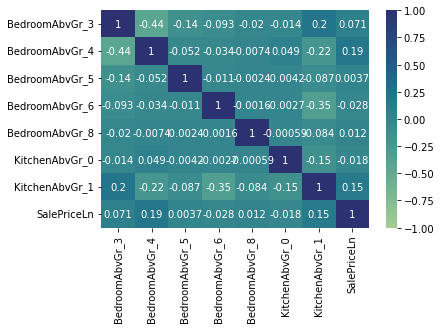

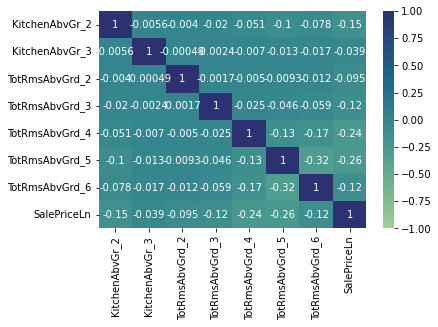

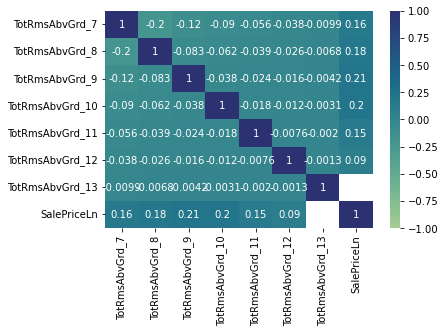

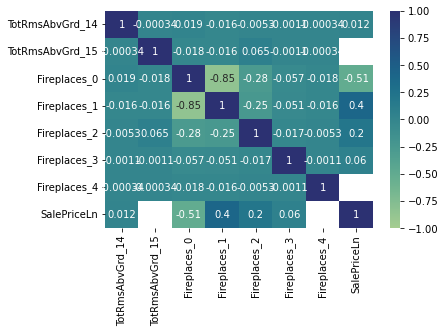

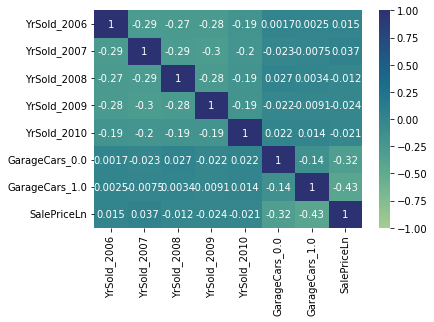

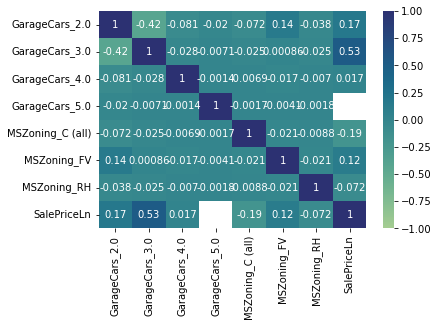

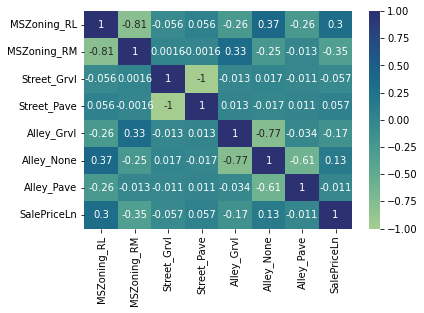

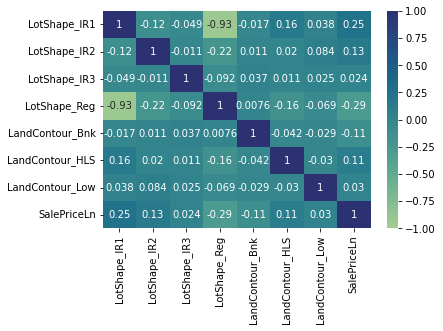

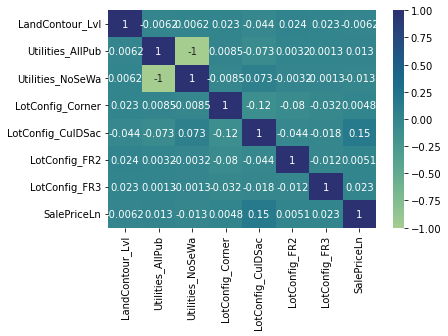

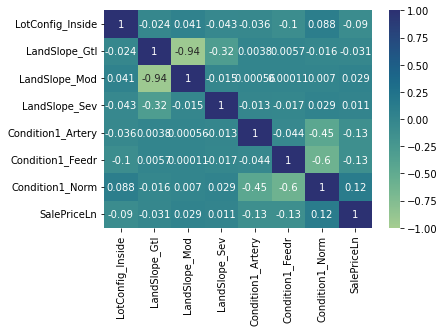

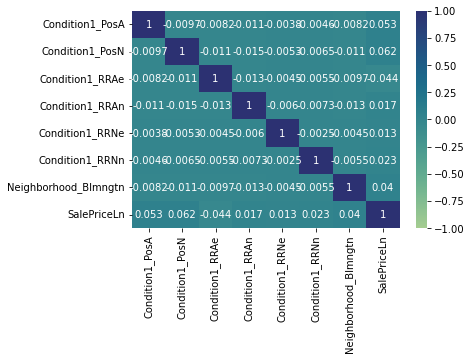

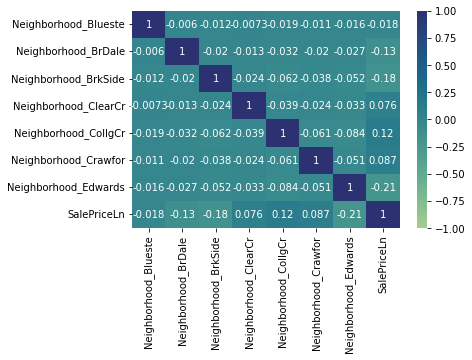

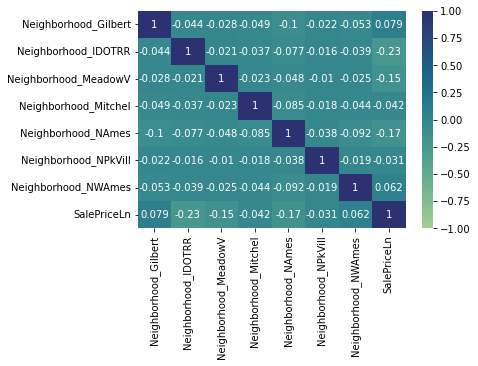

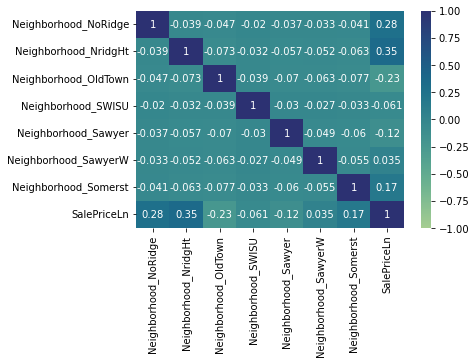

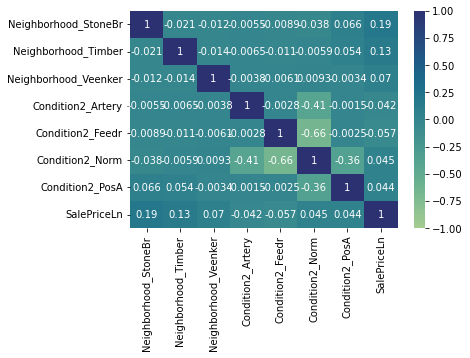

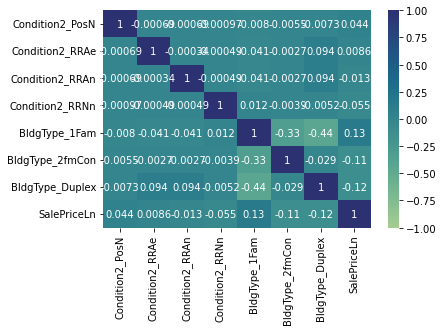

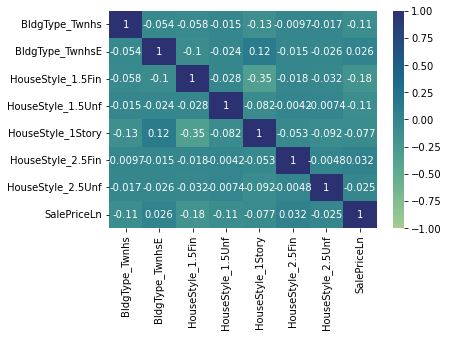

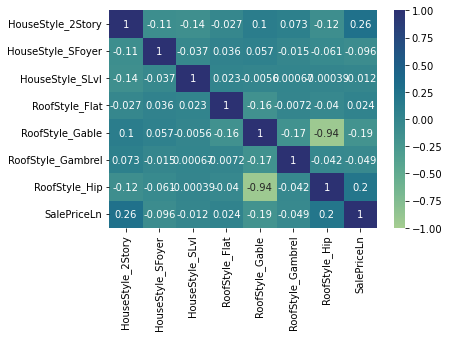

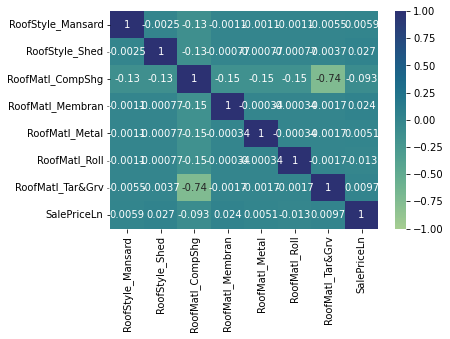

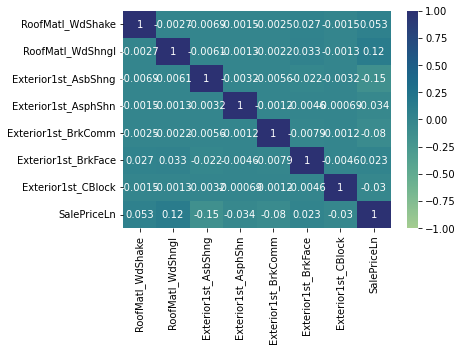

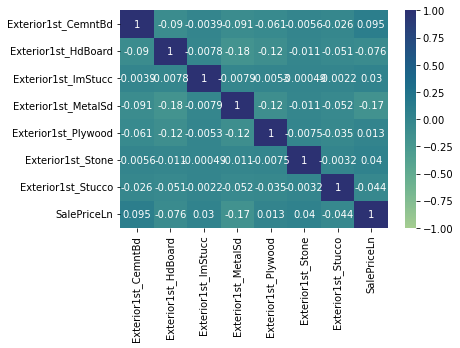

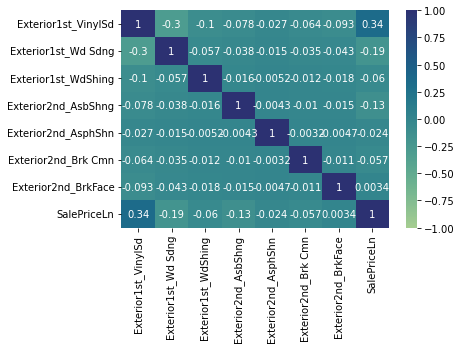

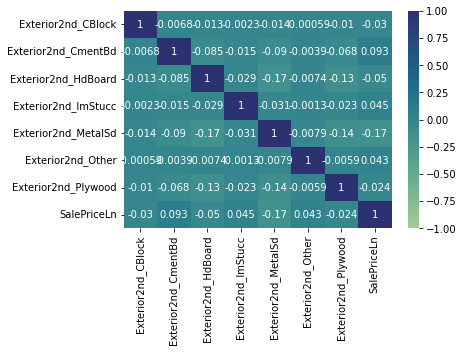

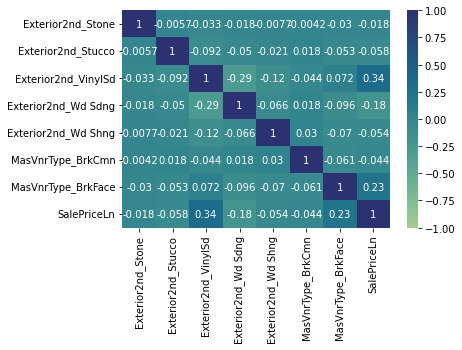

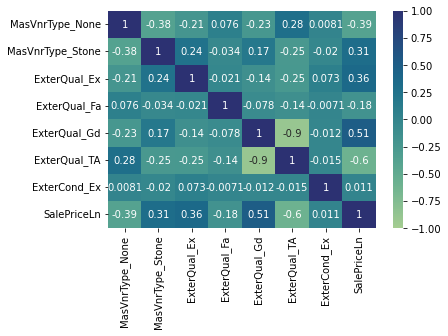

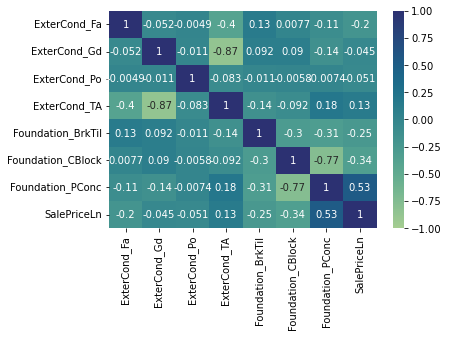

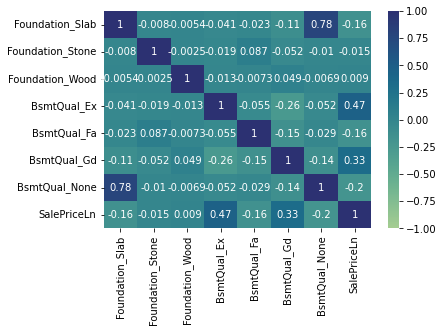

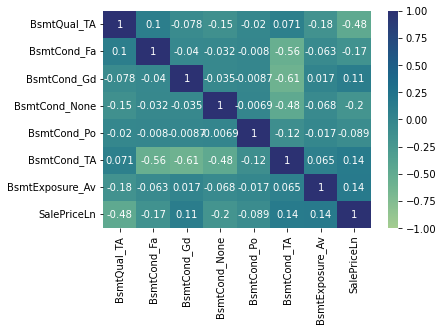

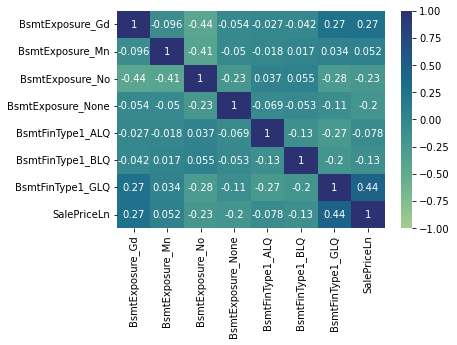

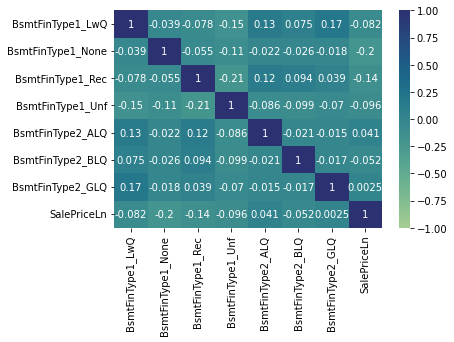

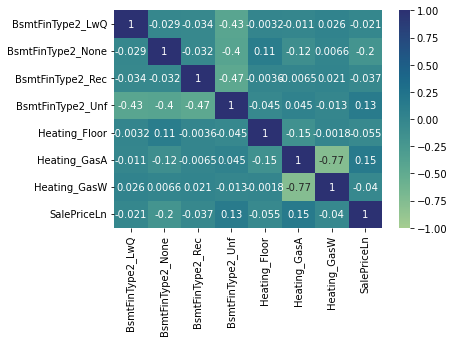

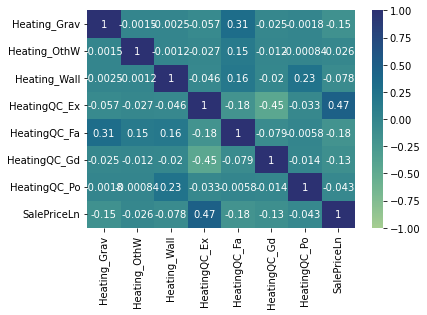

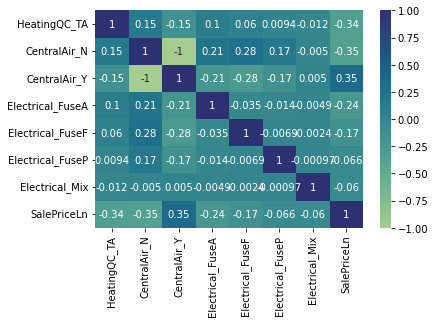

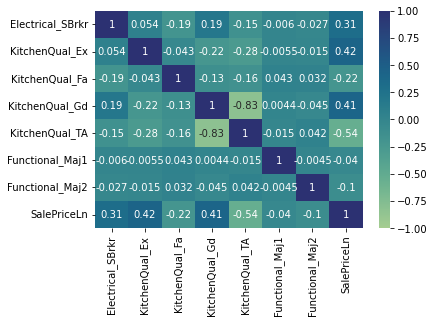

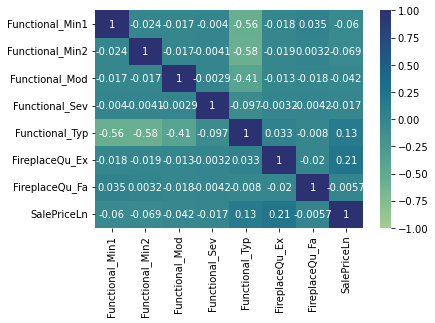

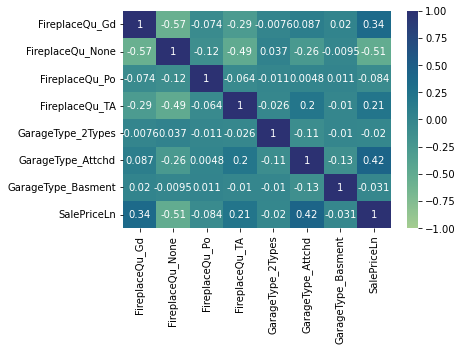

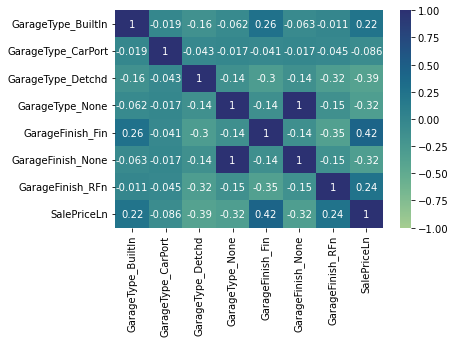

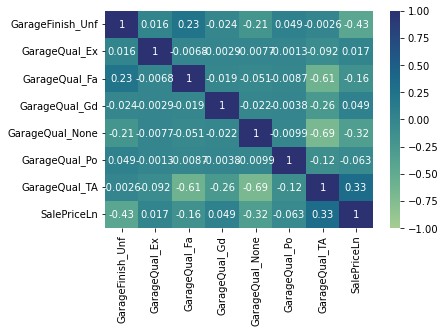

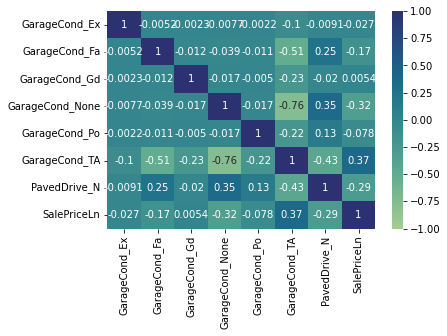

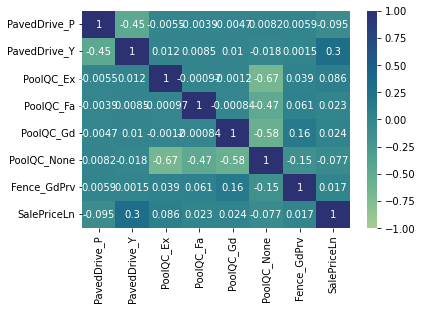

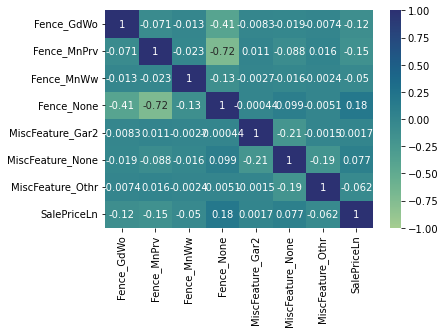

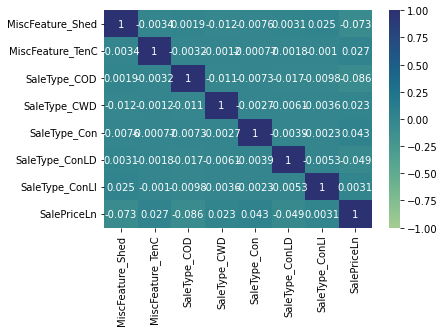

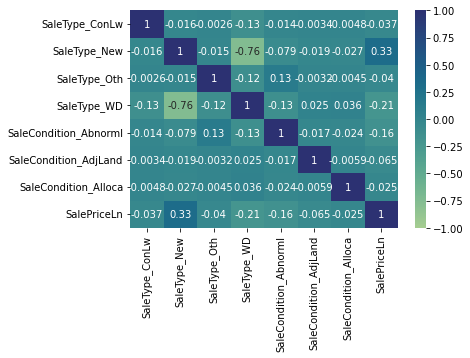

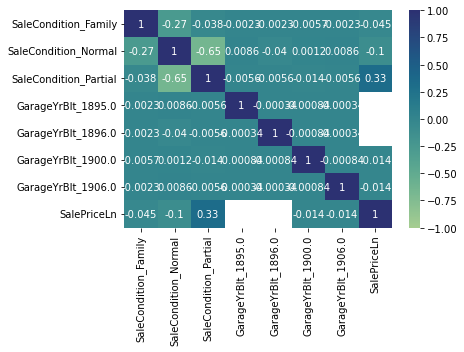

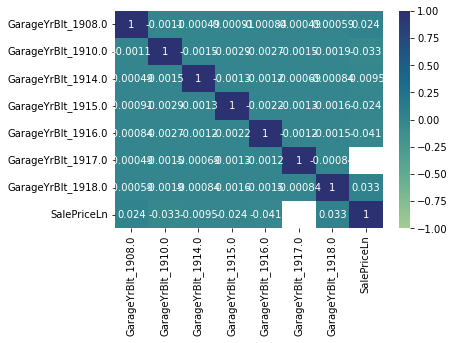

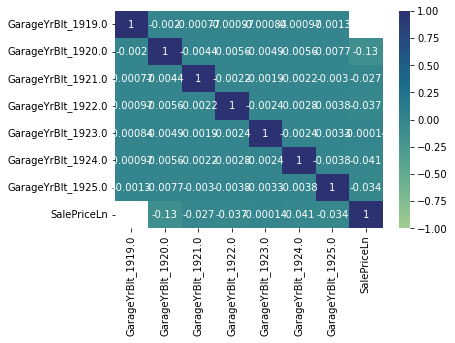

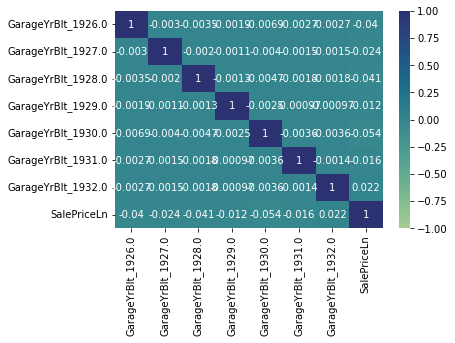

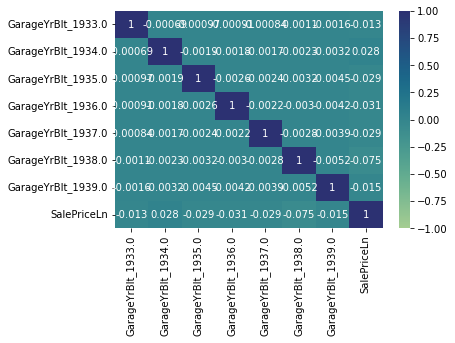

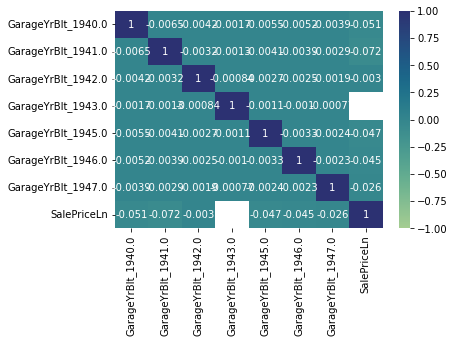

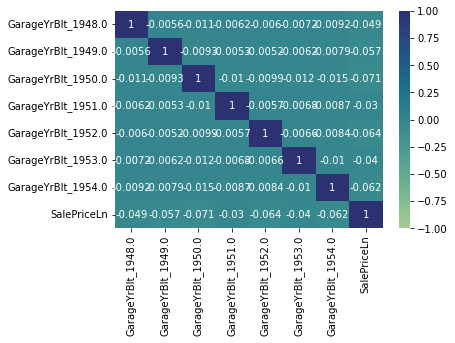

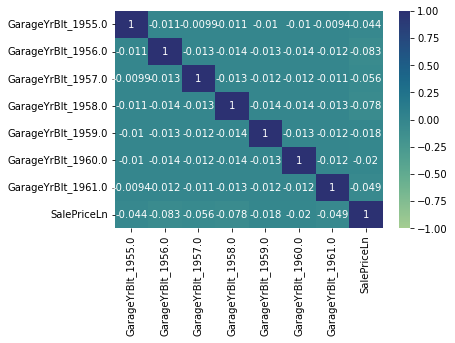

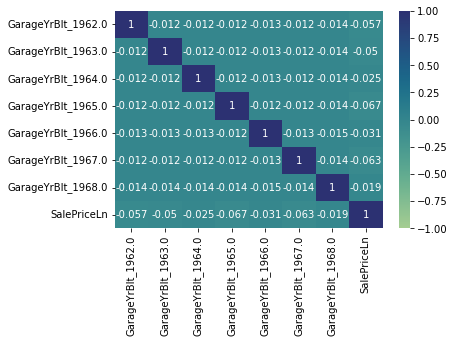

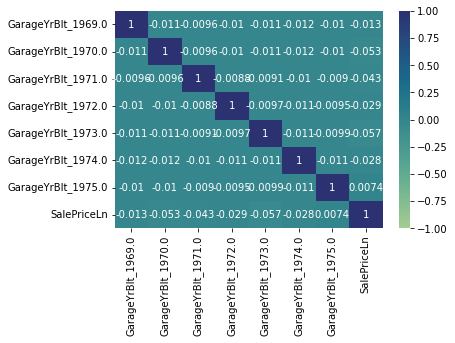

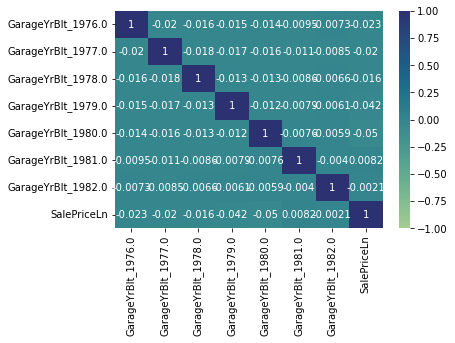

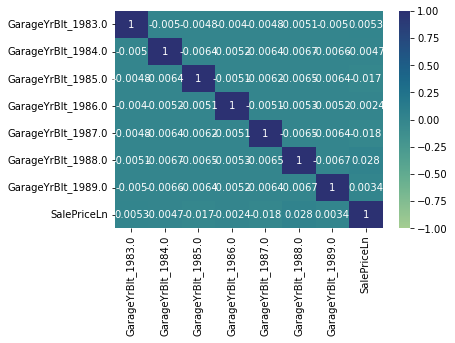

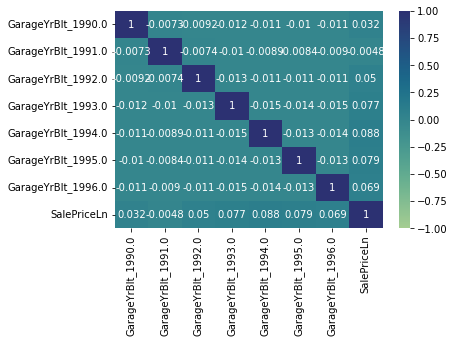

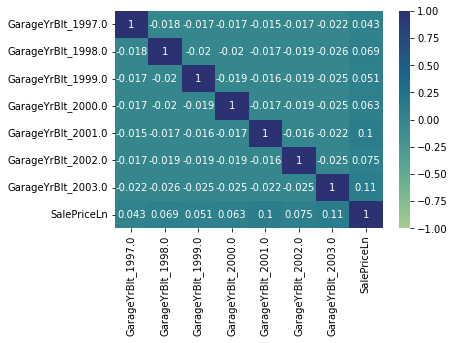

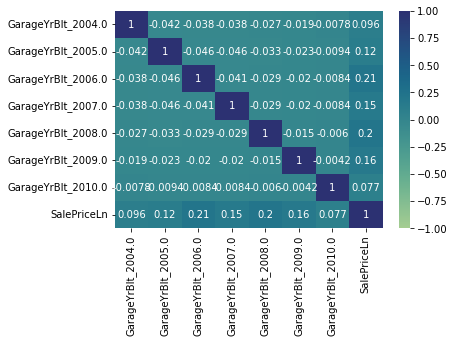

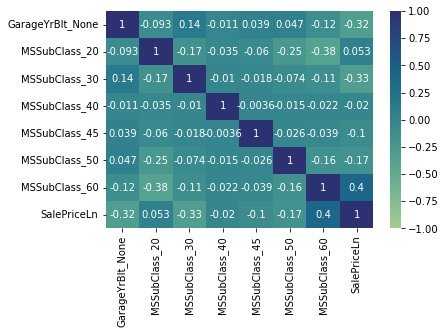

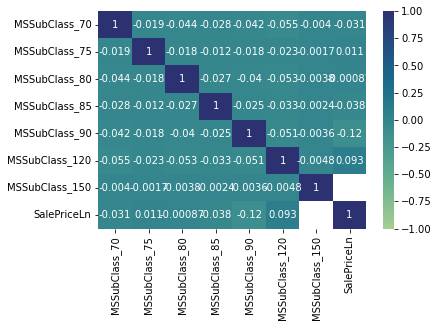

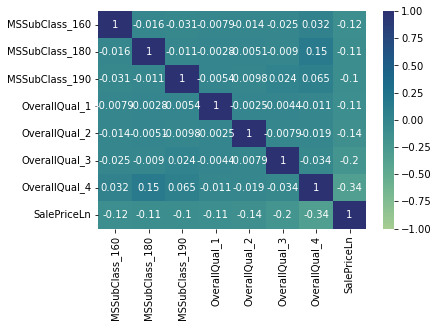

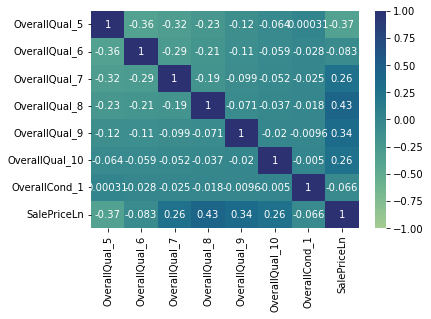

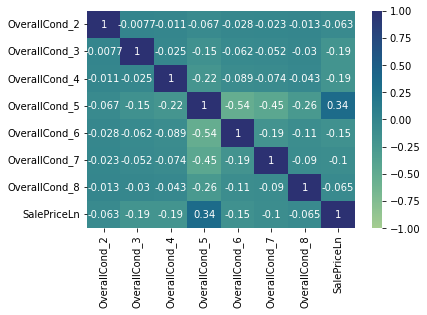

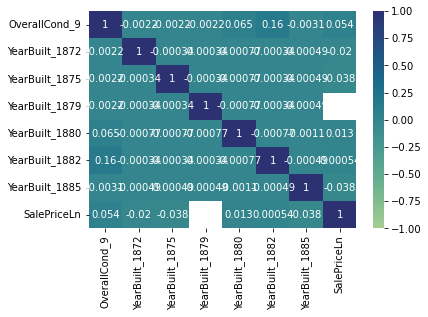

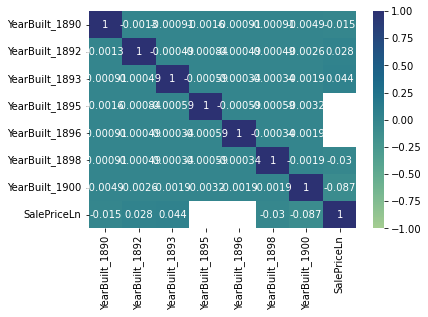

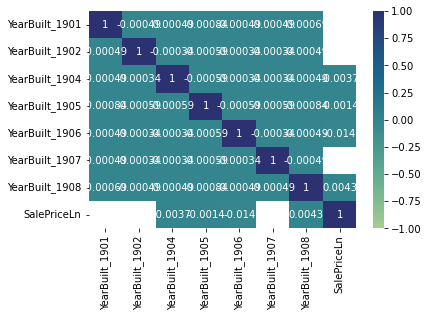

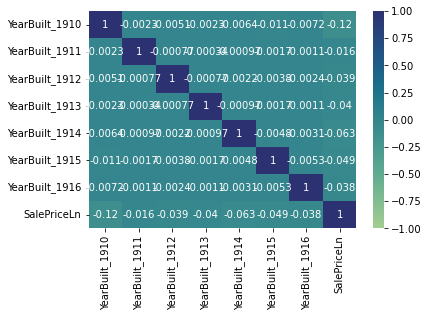

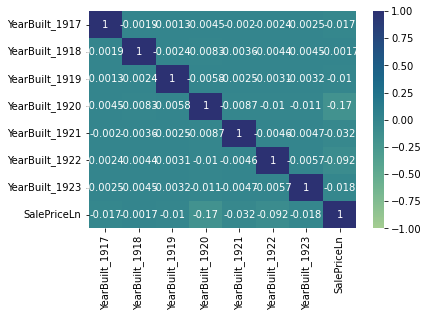

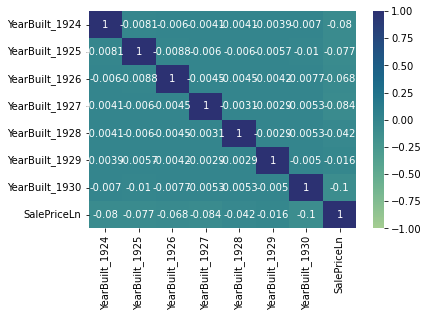

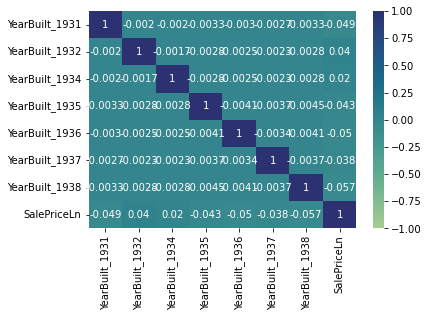

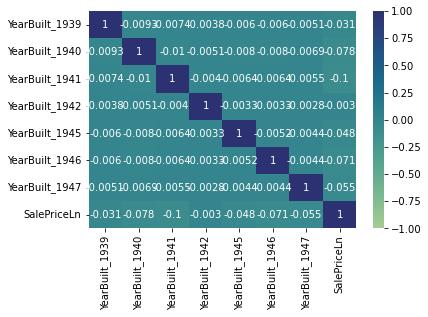

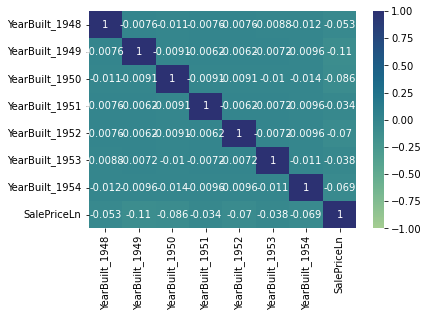

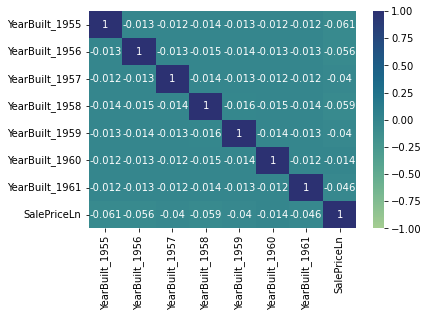

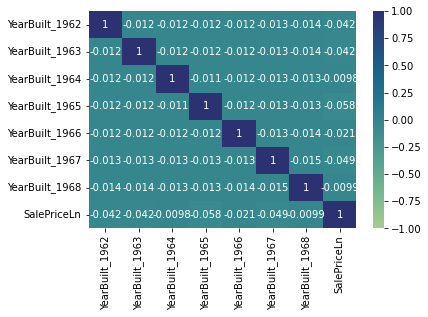

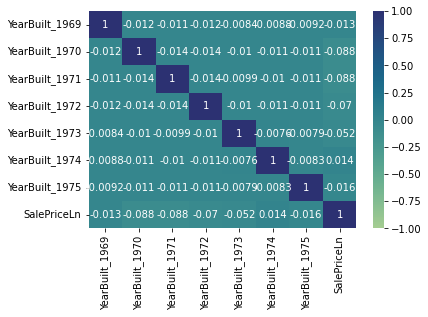

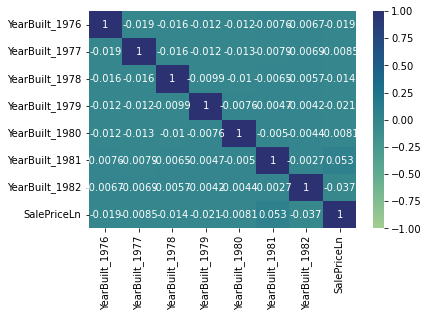

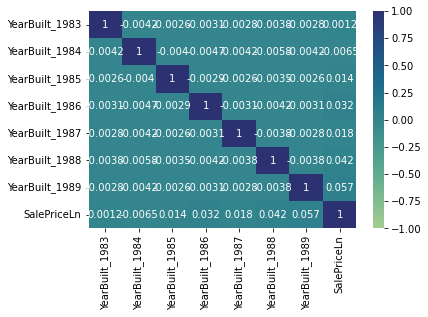

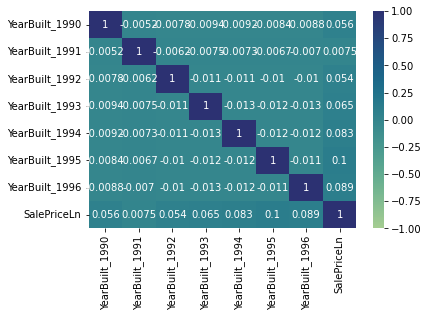

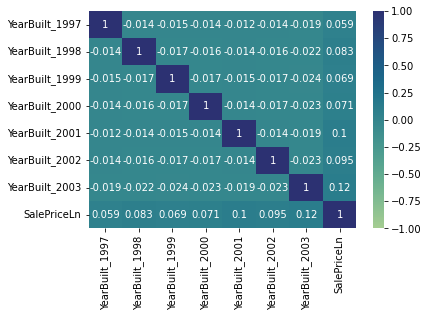

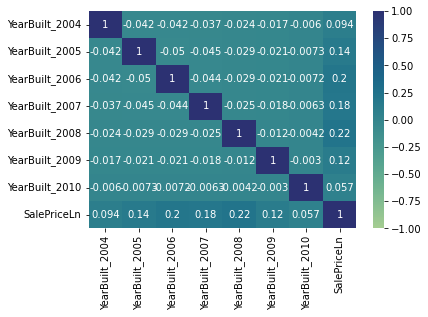

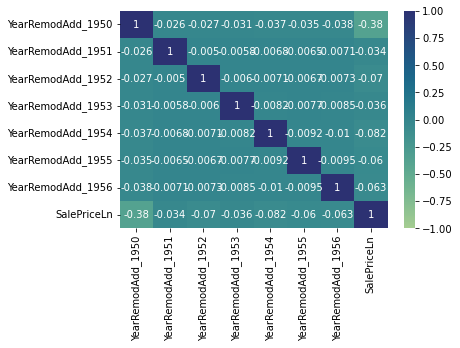

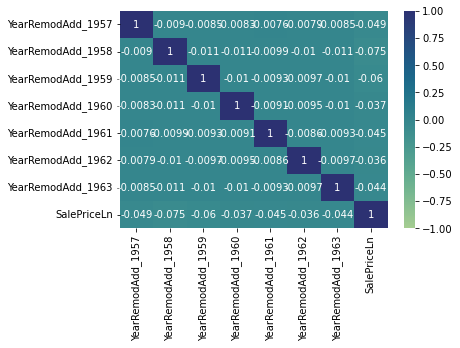

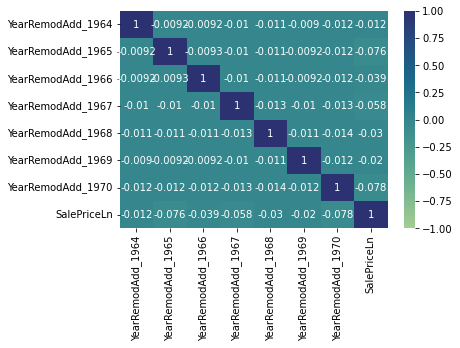

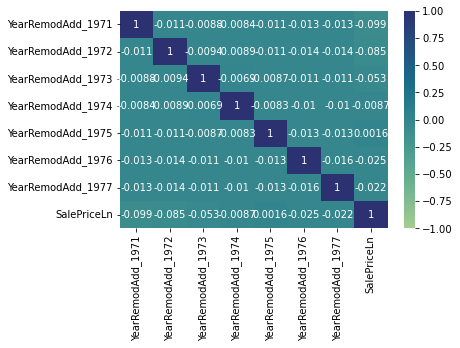

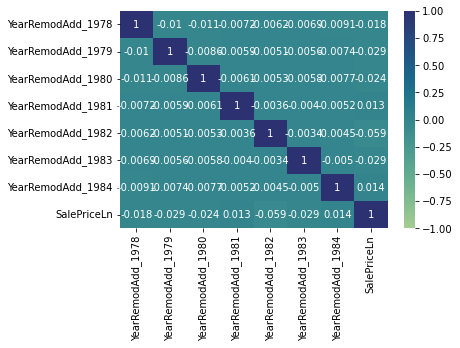

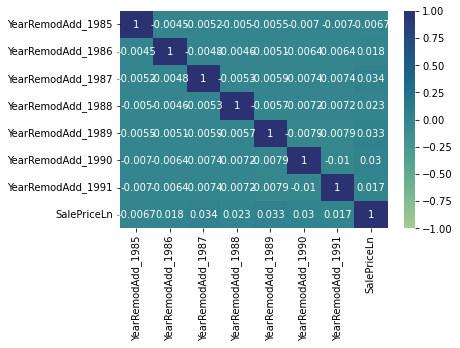

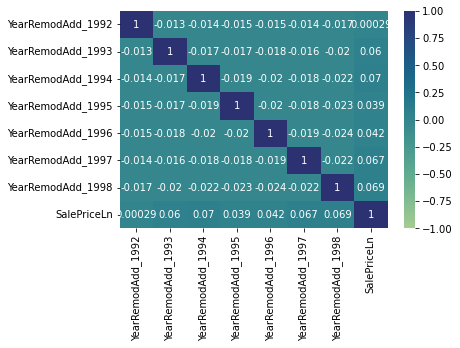

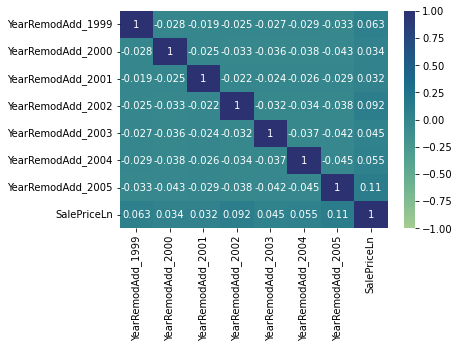

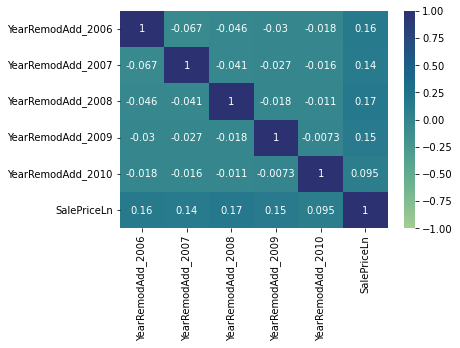

In [47]:
dependent_var = combined_encoded[['SalePriceLn']]

for i in range(0, len(combined_encoded), 7):
    last = i + 7
    temp1 = combined_encoded.iloc[:, i:last].merge(dependent_var, how='inner', left_index=True, right_index=True)
    if len(temp1.columns) == 1:
        break
    sn.heatmap(temp1.corr(), vmin = -1, vmax = 1, annot=True, cmap = 'crest')
    plt.show()

#### Correlation Heat Maps - Subset

I now generate heatmaps for the subset of variables that appear to have some correlation with SalePriceLn. I want to make sure I don't have collinearity.

In [48]:
subset_initial = combined_encoded[["LotArea","TotalBsmtSF","1stFlrSF","2ndFlrSF","GrLivArea","GarageArea","Baths","TotSF","OutdoorSF","BsmtFullBath_0.0","BsmtFullBath_1.0","FullBath_1",
                                   "FullBath_2","FullBath_3","HalfBath_0","HalfBath_1","TotRmsAbvGrd_4","TotRmsAbvGrd_5","Fireplaces_0","Fireplaces_1","GarageCars_0.0","GarageCars_1.0",
                                   "GarageCars_3.0","MSZoning_RL","MSZoning_RM","LotShape_IR1","LotShape_Reg","Neighborhood_NoRidge","Neighborhood_NridgHt","Neighborhood_OldTown",
                                   "HouseStyle_2Story","Exterior1st_VinylSd","Exterior2nd_VinylSd","MasVnrType_None","MasVnrType_Stone","ExterQual_Ex","ExterQual_Gd","ExterQual_TA",
                                   "Foundation_BrkTil","Foundation_CBlock","Foundation_PConc","BsmtQual_Ex","BsmtQual_Gd","BsmtQual_TA","BsmtExposure_Gd","BsmtFinType1_GLQ","HeatingQC_Ex",
                                   "HeatingQC_TA","CentralAir_Y","Electrical_FuseA","Electrical_SBrkr","KitchenQual_Ex","KitchenQual_Gd","KitchenQual_TA","FireplaceQu_Gd",
                                   "FireplaceQu_None","GarageType_Attchd","GarageType_Detchd","GarageType_None","GarageFinish_Fin","GarageFinish_None","GarageFinish_Unf",
                                   "GarageQual_None","GarageQual_TA","GarageCond_None","GarageCond_TA","PavedDrive_N","PavedDrive_Y","SaleType_New","SaleCondition_Partial",
                                   "GarageYrBlt_None","MSSubClass_30","MSSubClass_50","MSSubClass_60","OverallQual_1","OverallQual_2","OverallQual_3","OverallQual_4","OverallQual_5",
                                   "OverallQual_7","OverallQual_8","OverallQual_9","OverallQual_10","OverallCond_2","OverallCond_3","OverallCond_4","OverallCond_5","OverallCond_6",
                                   "OverallCond_7","OverallCond_8","OverallCond_9","YearRemodAdd_1950"]]

##### Heat Map Results

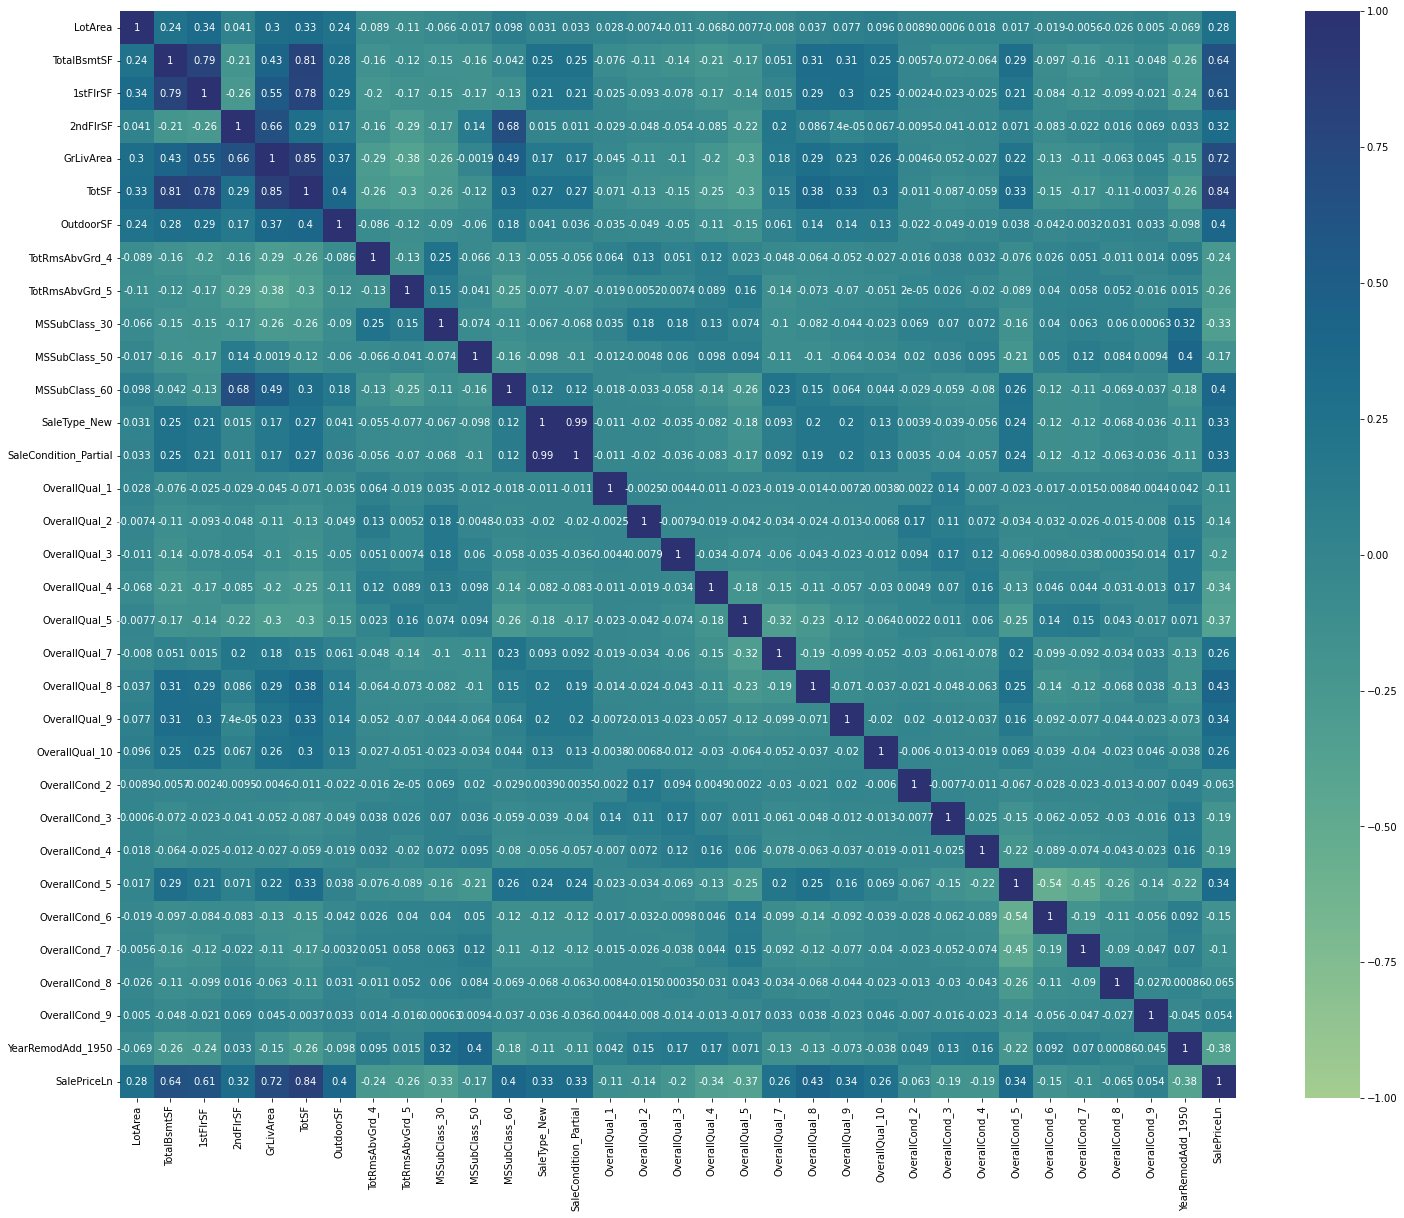

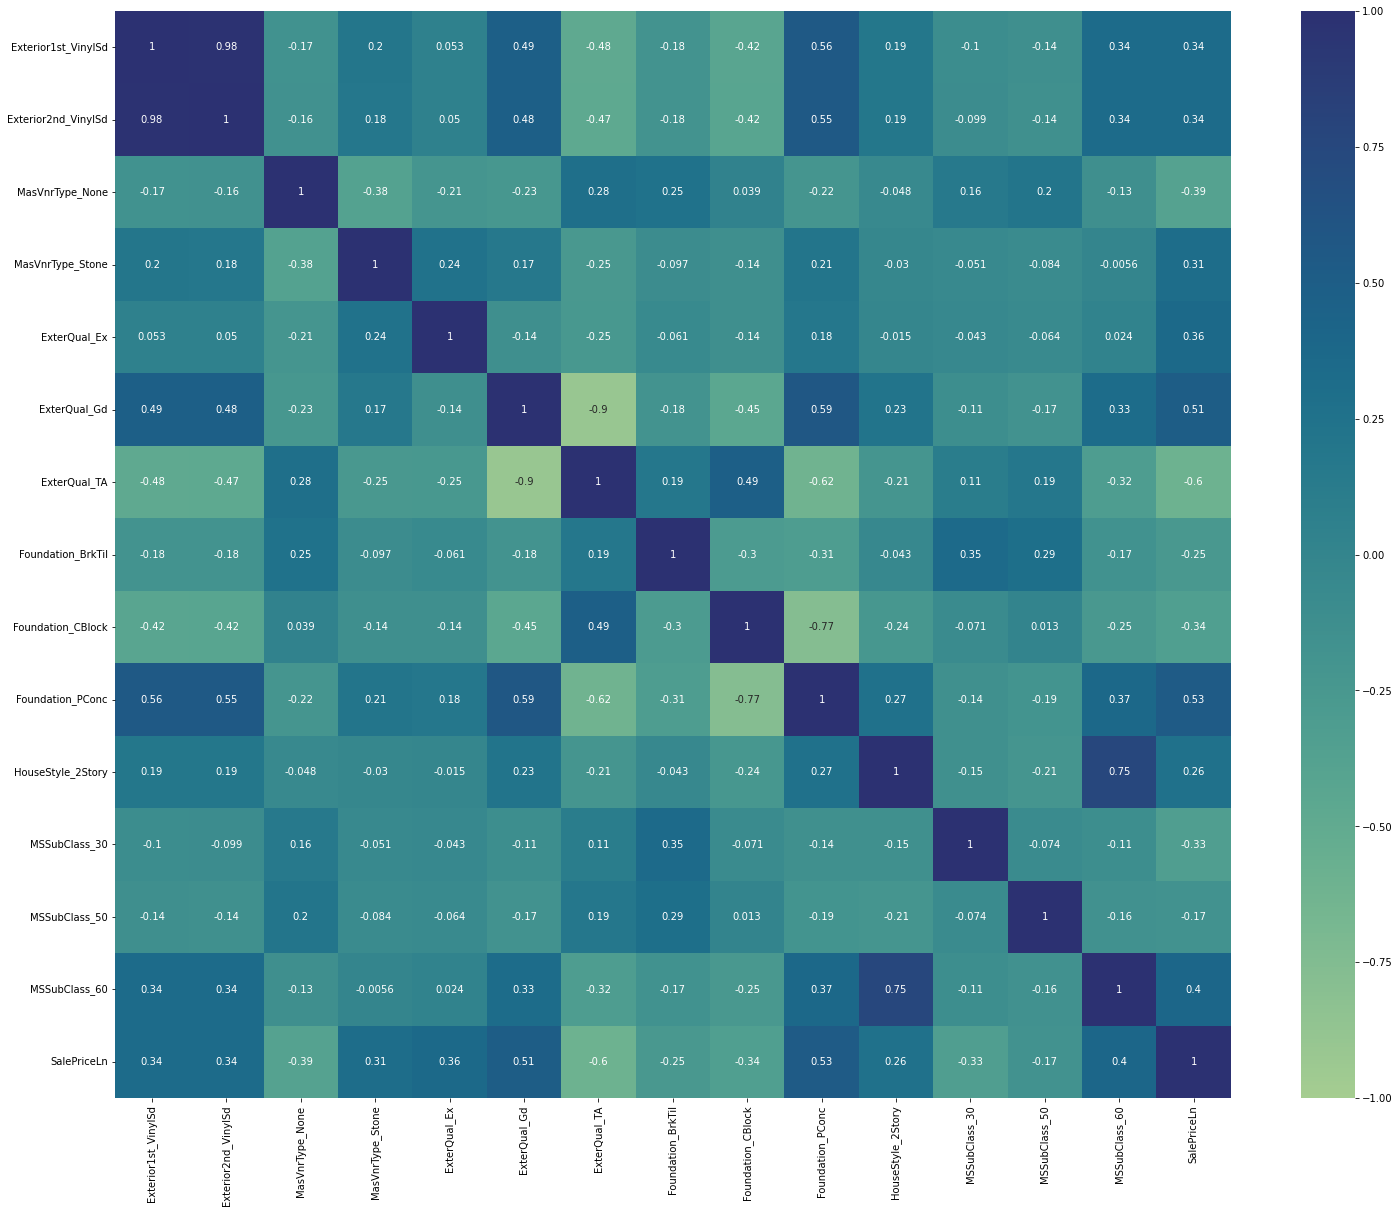

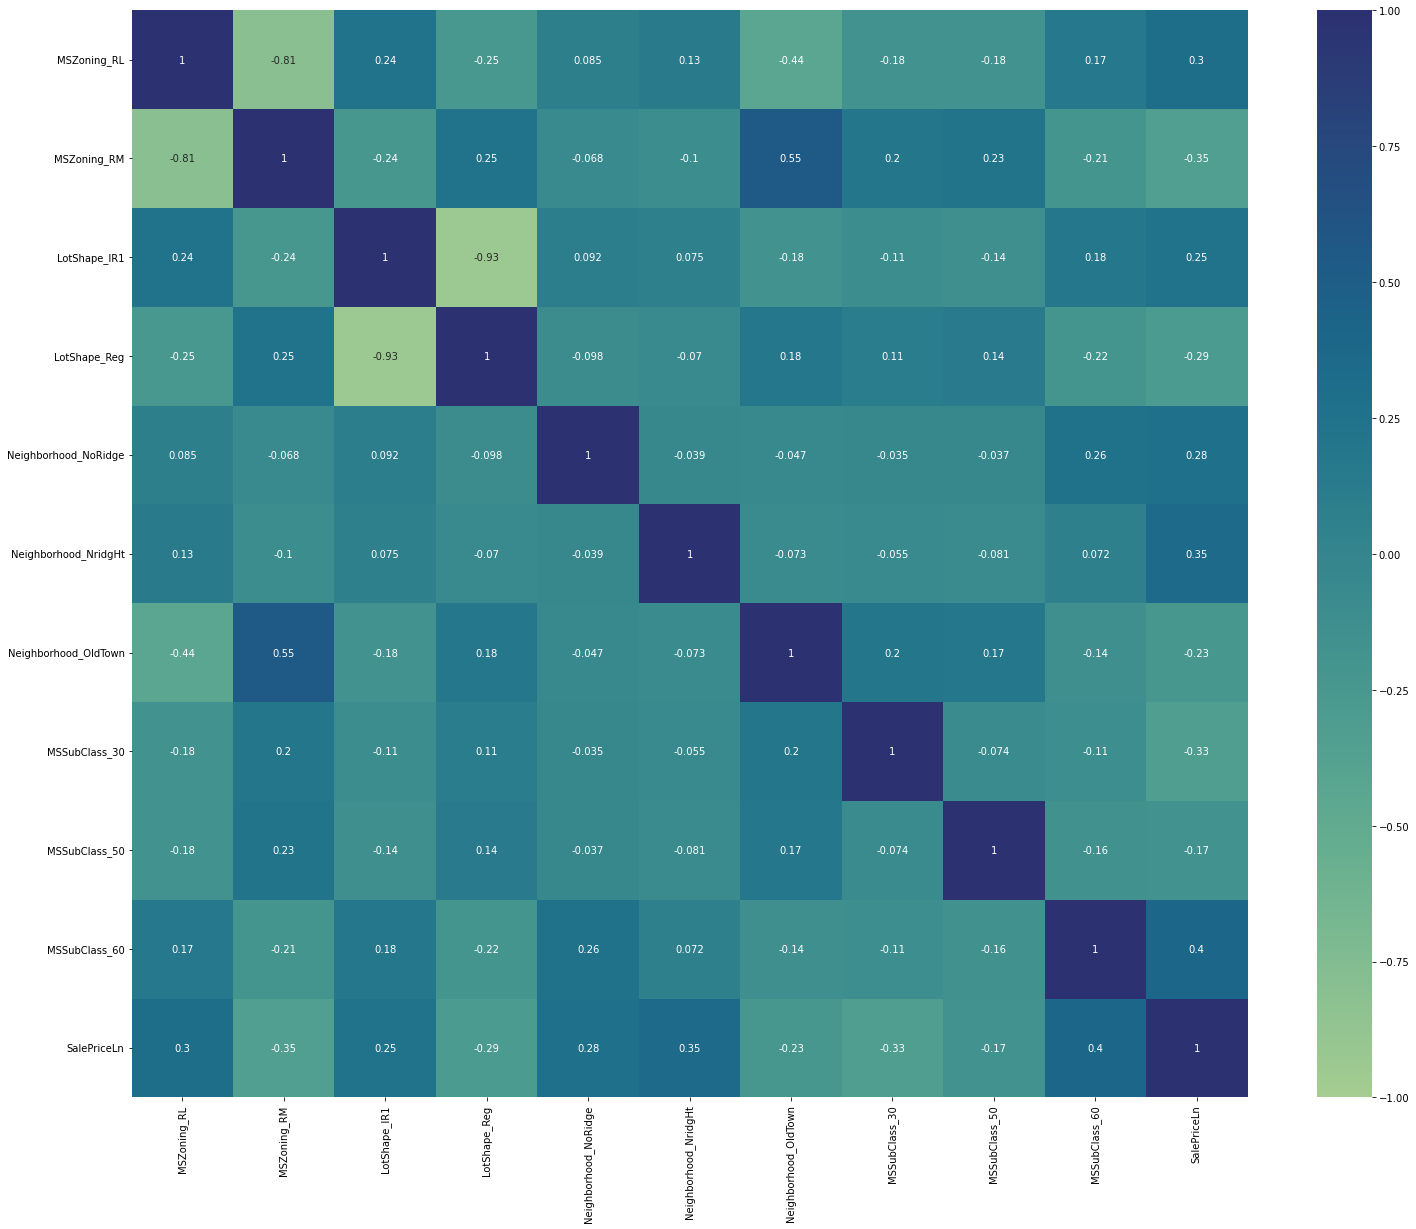

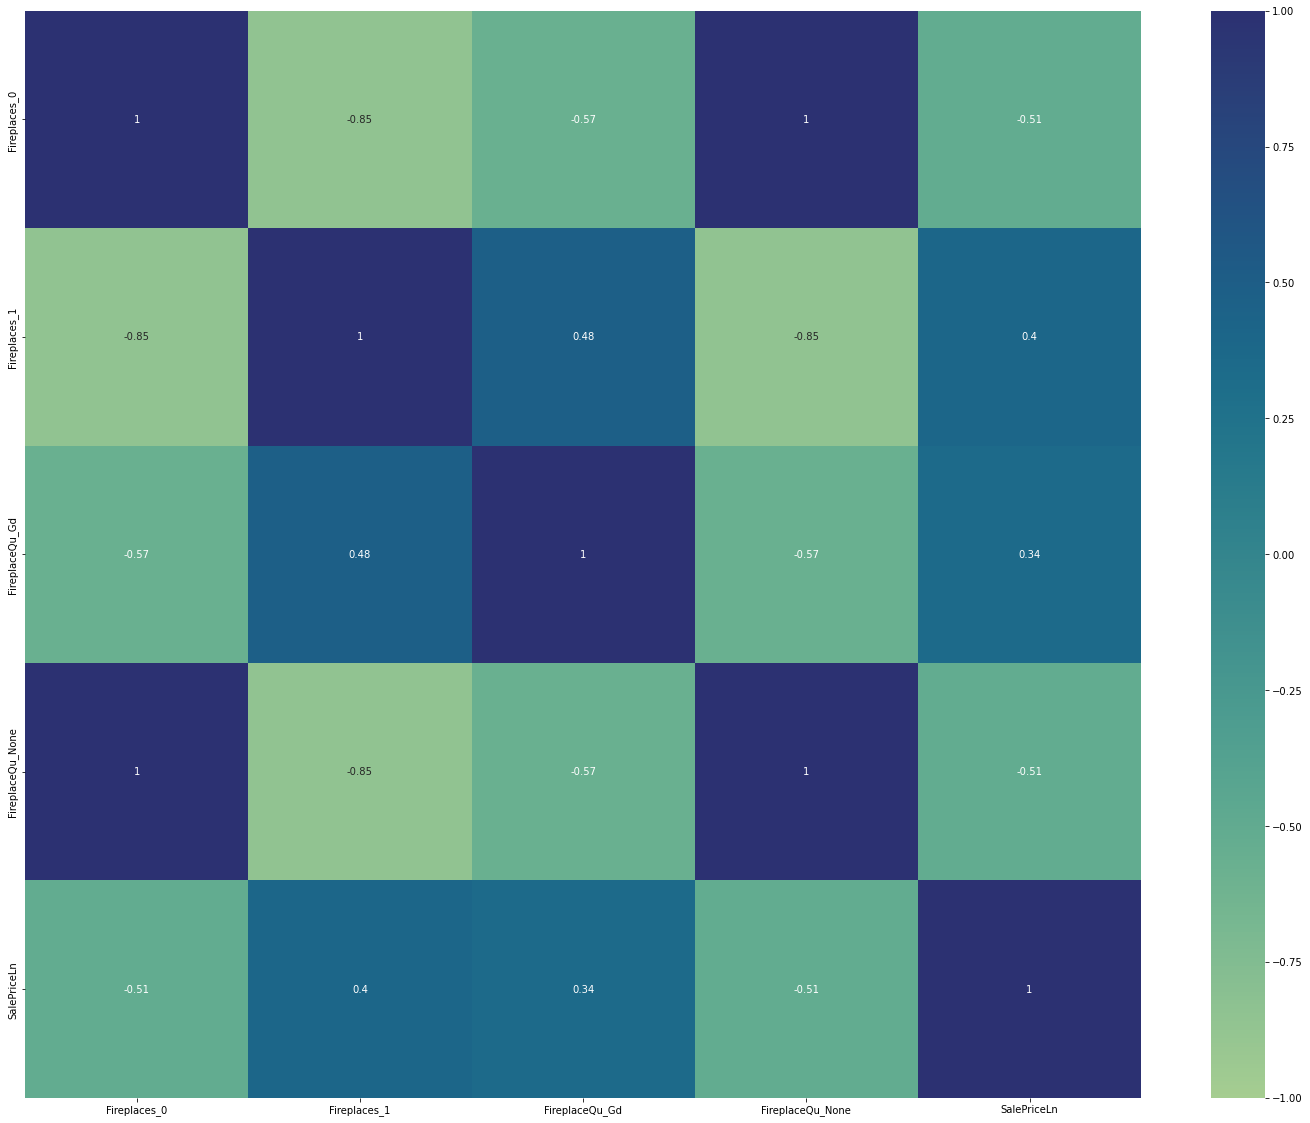

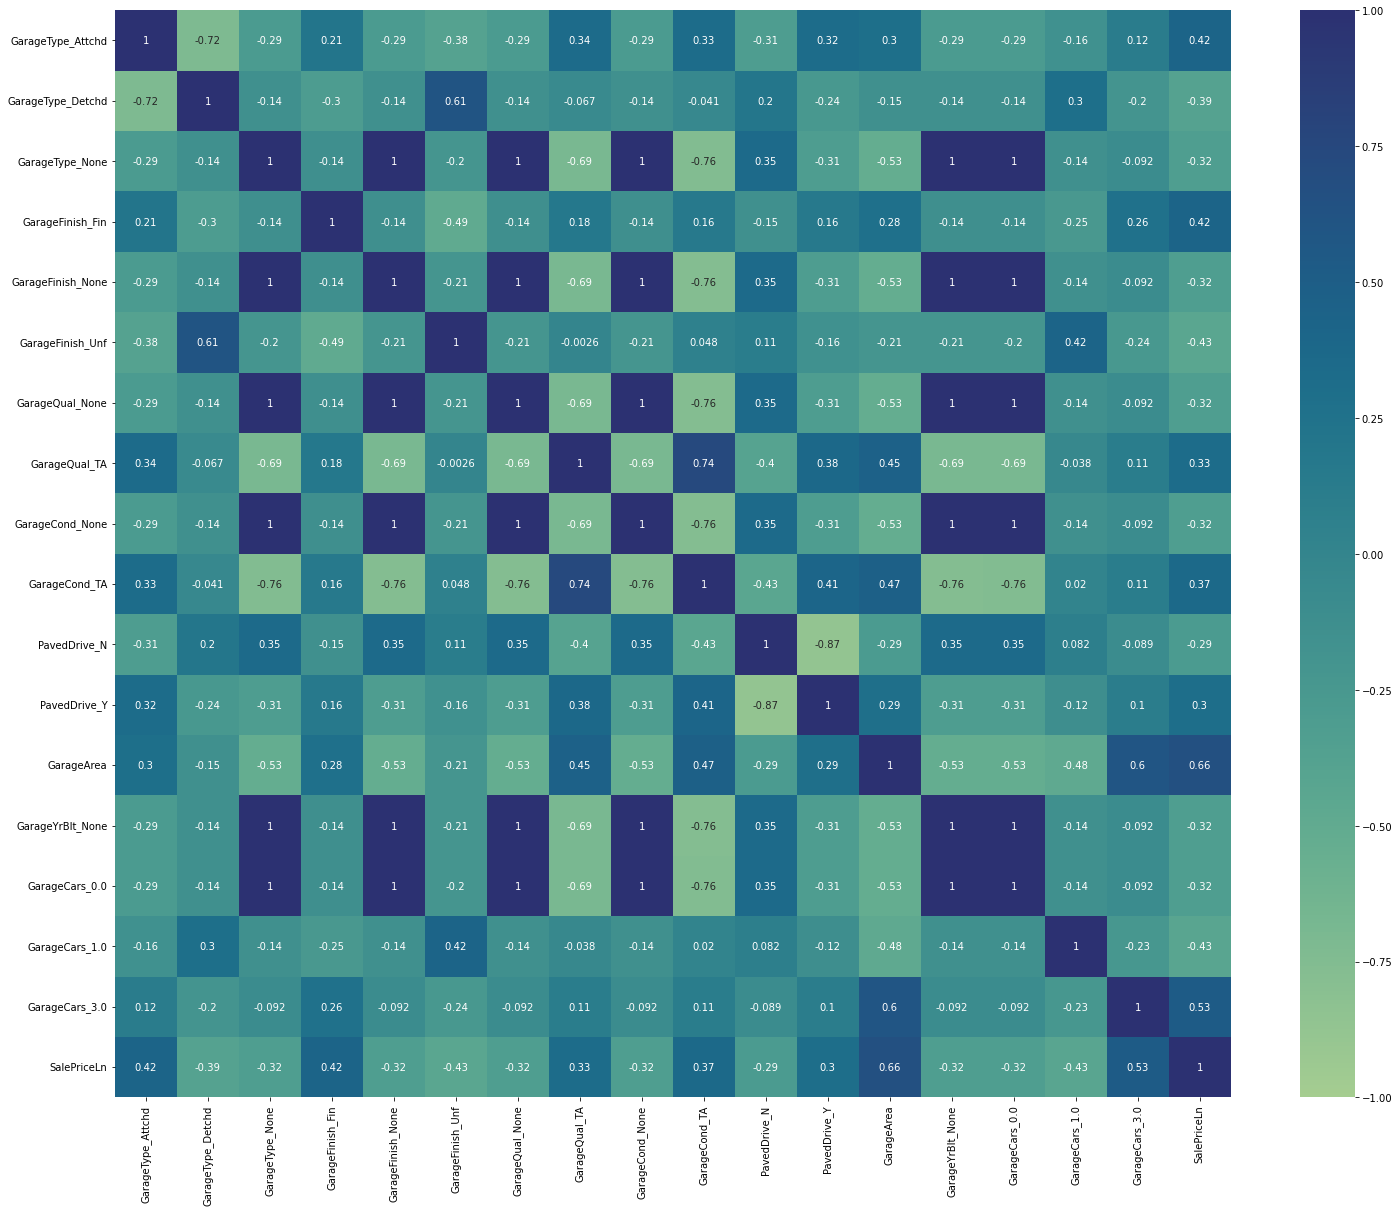

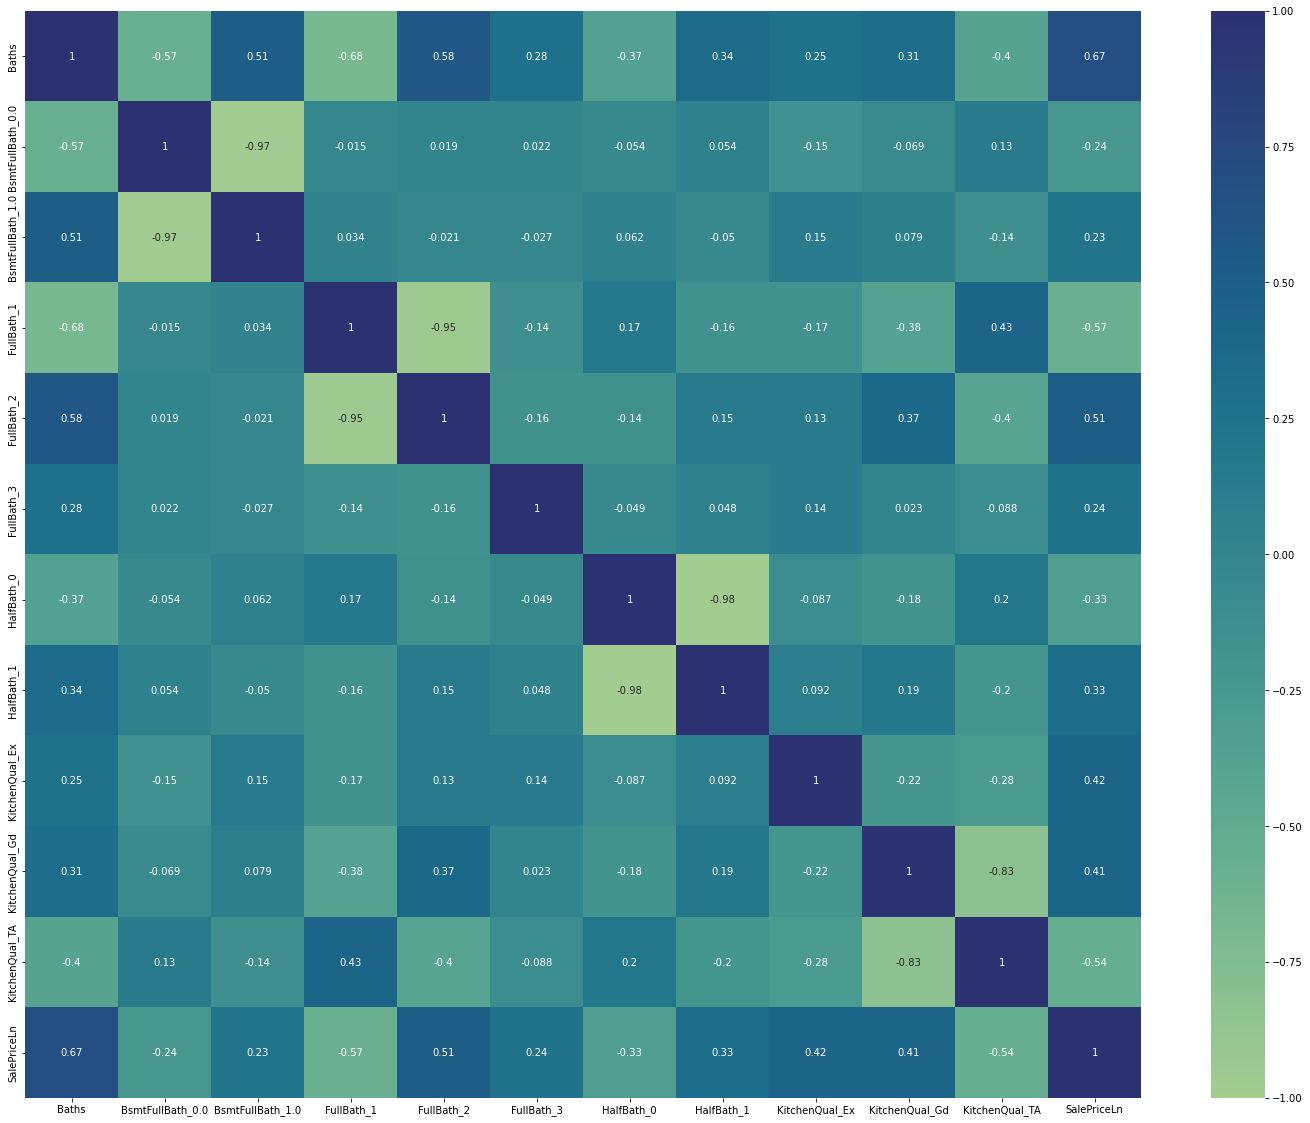

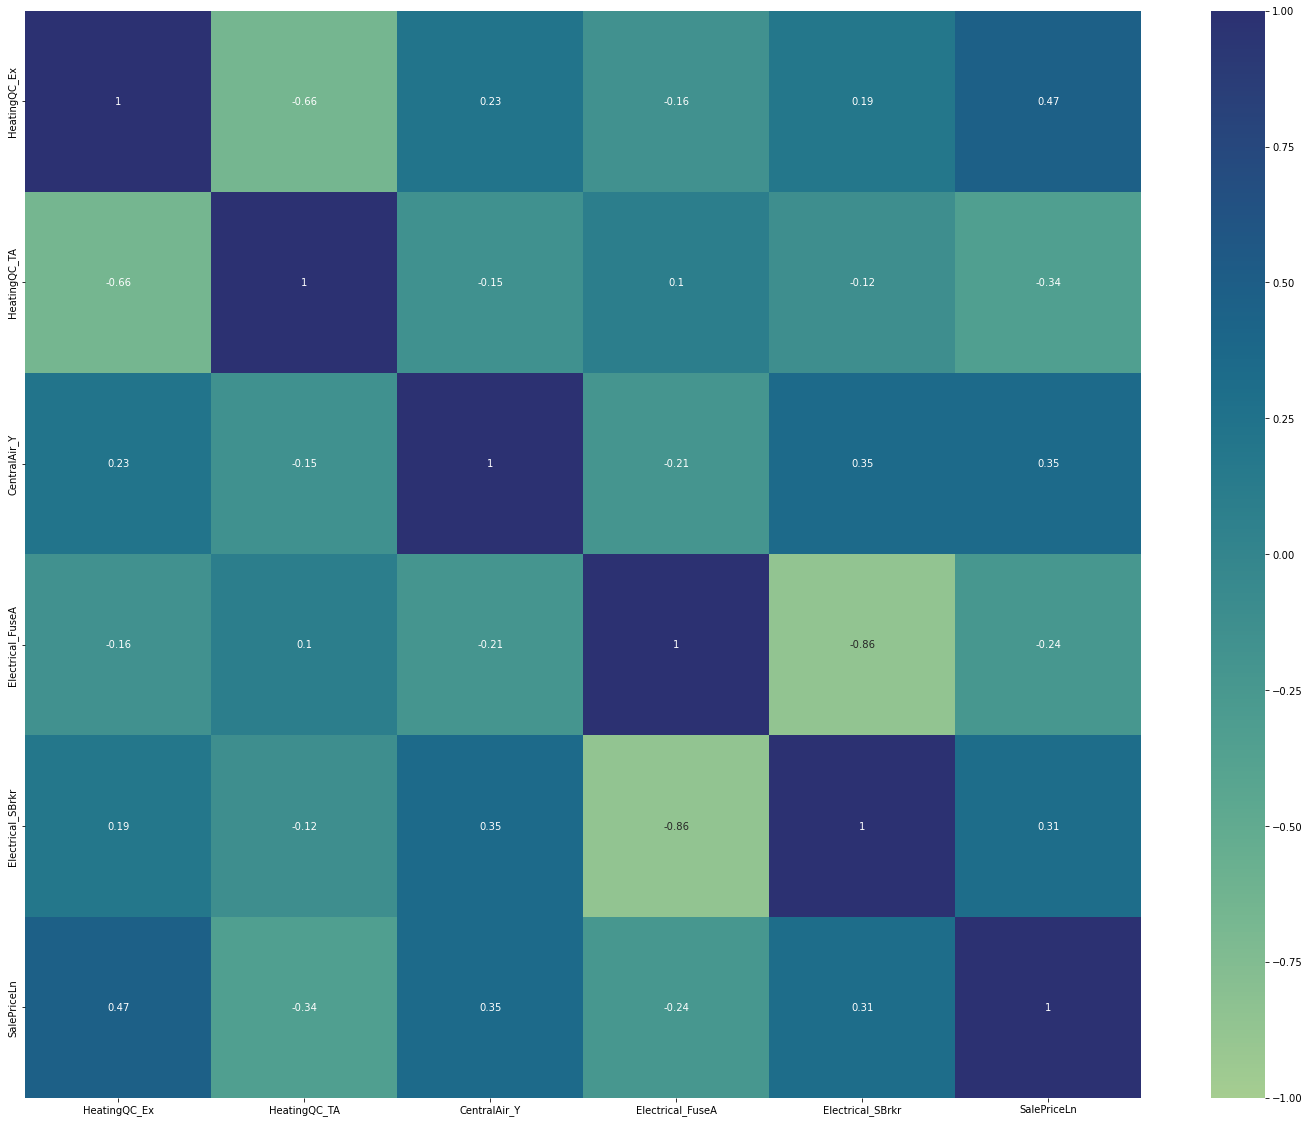

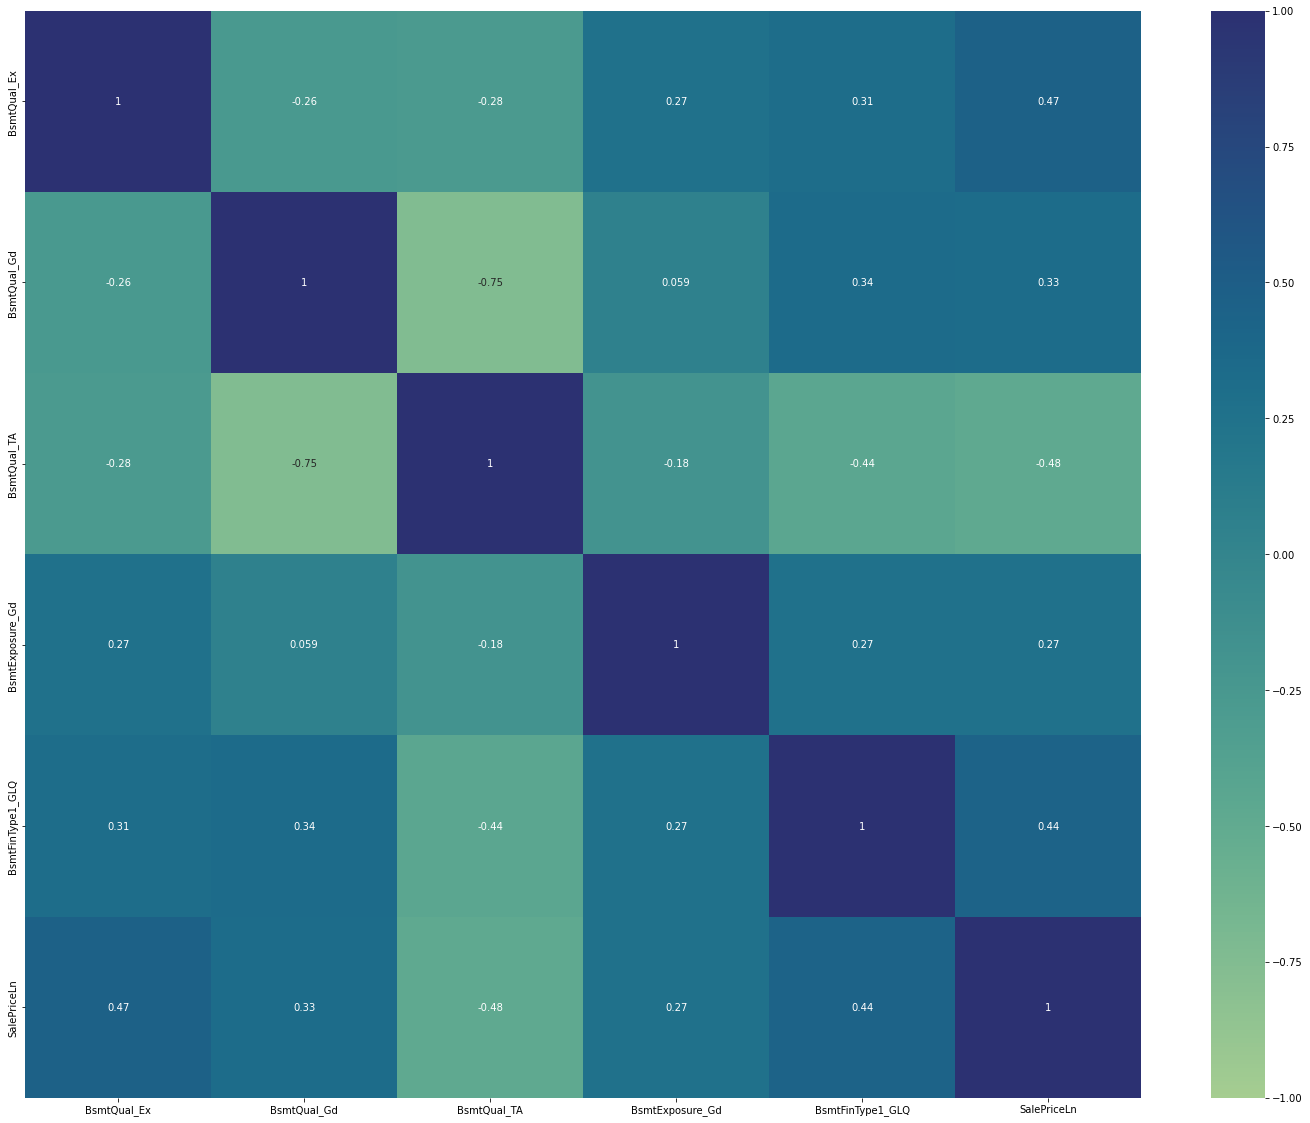

In [49]:
general_vars = ["LotArea","TotalBsmtSF","1stFlrSF","2ndFlrSF","GrLivArea","TotSF","OutdoorSF", "TotRmsAbvGrd_4","TotRmsAbvGrd_5", "MSSubClass_30","MSSubClass_50","MSSubClass_60",
               "SaleType_New","SaleCondition_Partial","OverallQual_1","OverallQual_2","OverallQual_3","OverallQual_4","OverallQual_5","OverallQual_7","OverallQual_8",
                "OverallQual_9","OverallQual_10","OverallCond_2","OverallCond_3","OverallCond_4","OverallCond_5","OverallCond_6","OverallCond_7","OverallCond_8","OverallCond_9",
                "YearRemodAdd_1950"]
exterior_vars = ["Exterior1st_VinylSd","Exterior2nd_VinylSd","MasVnrType_None","MasVnrType_Stone","ExterQual_Ex","ExterQual_Gd","ExterQual_TA","Foundation_BrkTil",
                 "Foundation_CBlock","Foundation_PConc", "HouseStyle_2Story", "MSSubClass_30","MSSubClass_50","MSSubClass_60"]
place_vars = ["MSZoning_RL","MSZoning_RM","LotShape_IR1","LotShape_Reg", "Neighborhood_NoRidge","Neighborhood_NridgHt","Neighborhood_OldTown", "MSSubClass_30","MSSubClass_50","MSSubClass_60"]
fireplace_vars = ["Fireplaces_0","Fireplaces_1", "FireplaceQu_Gd","FireplaceQu_None"]
garage_vars = ["GarageType_Attchd","GarageType_Detchd","GarageType_None","GarageFinish_Fin","GarageFinish_None","GarageFinish_Unf",
               "GarageQual_None","GarageQual_TA","GarageCond_None","GarageCond_TA","PavedDrive_N","PavedDrive_Y", "GarageArea", "GarageYrBlt_None", 
               "GarageCars_0.0","GarageCars_1.0","GarageCars_3.0"]
bathroom_kitchen_vars = ["Baths", "BsmtFullBath_0.0","BsmtFullBath_1.0","FullBath_1","FullBath_2","FullBath_3","HalfBath_0","HalfBath_1","KitchenQual_Ex","KitchenQual_Gd","KitchenQual_TA"]
utils_vars = ["HeatingQC_Ex","HeatingQC_TA","CentralAir_Y","Electrical_FuseA","Electrical_SBrkr"]
basement_vas = ["BsmtQual_Ex","BsmtQual_Gd","BsmtQual_TA","BsmtExposure_Gd","BsmtFinType1_GLQ",]

for i in [general_vars, exterior_vars, place_vars, fireplace_vars, garage_vars, bathroom_kitchen_vars, utils_vars, basement_vas]:
    temp1 = combined_encoded[i]
    temp2 = temp1.merge(dependent_var, how='inner', left_index=True, right_index=True)
    if len(temp2.columns) == 1:
        break
    plt.subplots(figsize=(25, 20))
    sn.heatmap(temp2.corr(), vmin = -1, vmax = 1, annot=True, cmap = 'crest')
    plt.show()

#### Subset Variables and Split Training & Test

Subset to the variables of interest

In [50]:
subset_final = combined_encoded[["LotArea","GarageArea","Baths","TotSF","OutdoorSF","BsmtFullBath_1.0",
                                   "FullBath_3","HalfBath_1","TotRmsAbvGrd_4","TotRmsAbvGrd_5","Fireplaces_0","GarageCars_0.0","GarageCars_1.0",
                                   "GarageCars_3.0","MSZoning_RM","LotShape_Reg","Neighborhood_NoRidge","Neighborhood_NridgHt","Neighborhood_OldTown",
                                   "HouseStyle_2Story","Exterior1st_VinylSd","MasVnrType_None","MasVnrType_Stone","ExterQual_Ex","ExterQual_TA",
                                   "Foundation_BrkTil","Foundation_PConc","BsmtQual_Ex","BsmtQual_TA","BsmtExposure_Gd","BsmtFinType1_GLQ","HeatingQC_Ex",
                                   "CentralAir_Y","Electrical_SBrkr","KitchenQual_Ex","KitchenQual_TA","FireplaceQu_Gd",
                                   "GarageType_Attchd","GarageFinish_Fin","GarageFinish_Unf",
                                   "GarageCond_None","GarageCond_TA","PavedDrive_Y","SaleType_New","SaleCondition_Partial",
                                   "MSSubClass_30","MSSubClass_50","MSSubClass_60","OverallQual_1","OverallQual_2","OverallQual_3","OverallQual_4","OverallQual_5",
                                   "OverallQual_7","OverallQual_8","OverallQual_9","OverallQual_10","OverallCond_2","OverallCond_3","OverallCond_4","OverallCond_5","OverallCond_6",
                                   "OverallCond_7","OverallCond_8","OverallCond_9","YearRemodAdd_1950"]]

Split between training and test datasets

In [51]:
train_model = subset_final.iloc[:1458, :]
test_model = subset_final.iloc[1458:, :]

train_model_y = dependent_var.iloc[:1458, :]

In [52]:
features = list(train_model.columns)

In [53]:
print(train_model.shape)
print(test_model.shape)

print(train_model_y.shape)

(1458, 66)
(1459, 66)
(1458, 1)


#### Scaling

In [54]:
min_max_scaler_y = MinMaxScaler()
min_max_scaler_x = MinMaxScaler()

In [55]:
X_train = min_max_scaler_x.fit_transform(train_model)
y_train = min_max_scaler_y.fit_transform(train_model_y)
X_test = min_max_scaler_x.fit_transform(test_model)

In [56]:
print(y_train)

[[0.58143069]
 [0.53631912]
 [0.60402899]
 ...
 [0.66126699]
 [0.45677119]
 [0.46884616]]


## Modeling

### Lasso Regression

Since we have a rather high dimensional data set (66 variables and 1458 observations), I use LassoCV instead of LassoLarsCV.

Commentary needed about fitting (# Determine the lambda constant through cross-validation k=5. The model is then fitted after the optimal lambda is chosen)
R^2 and RMSE and then subsequent cross validation results. Built in cross validation 

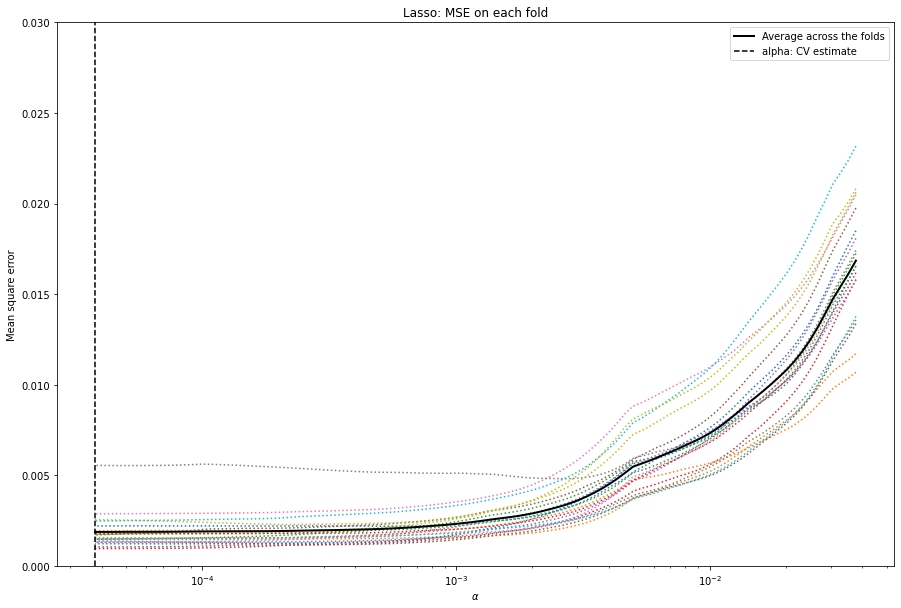

In [57]:
lasso_reg = make_pipeline(LassoCV(cv=20, random_state=0)).fit(X_train, y_train.ravel())

ymin, ymax = 0, .03
lasso = lasso_reg[-1]
plt.subplots(figsize=(15, 10))
plt.semilogx(lasso.alphas_, lasso.mse_path_, linestyle=":")
plt.plot(
    lasso.alphas_,
    lasso.mse_path_.mean(axis=-1),
    color="black",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(lasso.alpha_, linestyle="--", color="black", label="alpha: CV estimate")

plt.ylim(ymin, ymax)
plt.xlabel(r"$\alpha$")
plt.ylabel("Mean square error")
plt.legend()
_ = plt.title("Lasso: MSE on each fold")

In [58]:
eli5.show_weights(lasso_reg[-1], feature_names = features)

In [59]:
mean_squared_error(y_train, lasso_reg.predict(X_train), squared=True)

0.0016420364684689493

### Ridge Regression

commentary - build in cross validation to pick alpha

In [69]:
ridge_reg = RidgeCV(cv = None, store_cv_values = True).fit(X_train, y_train.ravel())

In [70]:
eli5.show_weights(ridge_reg, feature_names = features)

In [71]:
mean_squared_error(y_train, ridge_reg.predict(X_train), squared=True)

0.001636639886657197

In [72]:
ridge_reg.alpha_

0.1

In [73]:
ridge_reg.cv_values_

array([[1.55403572e-04, 1.58052931e-04, 1.43141478e-04],
       [4.23254147e-04, 4.70254701e-04, 3.82394682e-04],
       [3.35977934e-05, 2.18697154e-05, 4.52591424e-07],
       ...,
       [2.37439183e-03, 3.29532366e-03, 6.16051913e-03],
       [4.07800529e-06, 7.98109396e-06, 3.49895650e-05],
       [3.79789608e-04, 4.57633724e-04, 6.43992338e-04]])

### ElasticNet

commentary

In [83]:
elasticnet_reg = ElasticNetCV(cv = 20, random_state = 0).fit(X_train, y_train.ravel())

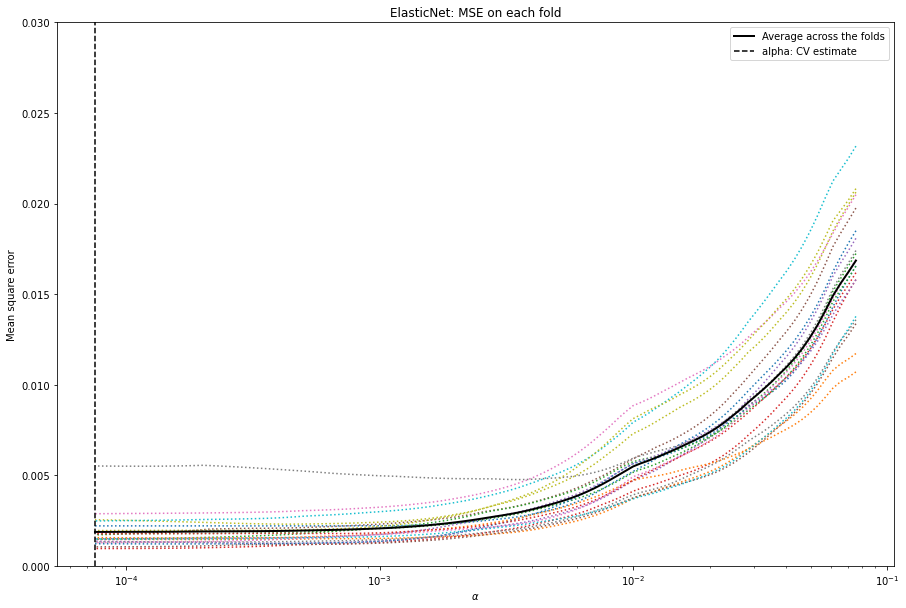

In [84]:
ymin, ymax = 0, .03
plt.subplots(figsize=(15, 10))
plt.semilogx(elasticnet_reg.alphas_, elasticnet_reg.mse_path_, linestyle=":")
plt.plot(
    elasticnet_reg.alphas_,
    elasticnet_reg.mse_path_.mean(axis=-1),
    color="black",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(elasticnet_reg.alpha_, linestyle="--", color="black", label="alpha: CV estimate")

plt.ylim(ymin, ymax)
plt.xlabel(r"$\alpha$")
plt.ylabel("Mean square error")
plt.legend()
_ = plt.title("ElasticNet: MSE on each fold")

In [85]:
eli5.show_weights(elasticnet_reg, feature_names = features)

In [86]:
mean_squared_error(y_train, elasticnet_reg.predict(X_train), squared=True)

0.001642915040976756

#### Hyperparameter Tuning

In [88]:
elasticnet_reg.get_params()

{'alphas': None,
 'copy_X': True,
 'cv': 20,
 'eps': 0.001,
 'fit_intercept': True,
 'l1_ratio': 0.5,
 'max_iter': 1000,
 'n_alphas': 100,
 'n_jobs': None,
 'normalize': 'deprecated',
 'positive': False,
 'precompute': 'auto',
 'random_state': 0,
 'selection': 'cyclic',
 'tol': 0.0001,
 'verbose': 0}

In [98]:
gs = GridSearchCV(estimator=ElasticNetCV(random_state = 0),
                  scoring = 'neg_root_mean_squared_error',
                  param_grid={'l1_ratio': [.1, .2, .3, .4, .5, .6, .7, .8, .9],
                              'cv': [3, 5, 10, 20, 40],
                              'n_alphas': [50, 100, 150],
                              'max_iter': [500, 1000, 1500]},
                  return_train_score = True
                 )

In [99]:
gs.fit(X_train, y_train.ravel())

GridSearchCV(estimator=ElasticNetCV(random_state=0),
             param_grid={'cv': [3, 5, 10, 20, 40],
                         'l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                      0.9],
                         'max_iter': [500, 1000, 1500],
                         'n_alphas': [50, 100, 150]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [101]:
gs.best_estimator_

ElasticNetCV(cv=5, l1_ratio=0.9, max_iter=500, n_alphas=50, random_state=0)

In [102]:
gs.best_score_

-0.043723237413123464

In [112]:
elasticnet_reg_updated = ElasticNetCV(cv = 5, l1_ratio=0.9, max_iter=500, n_alphas=50, random_state = 0).fit(X_train, y_train.ravel())

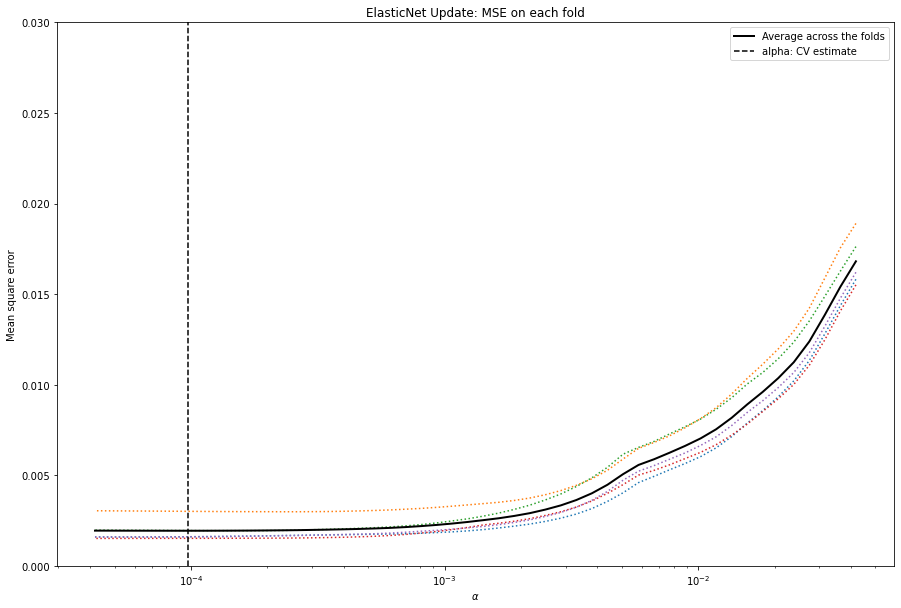

In [113]:
ymin, ymax = 0, .03
plt.subplots(figsize=(15, 10))
plt.semilogx(elasticnet_reg_updated.alphas_, elasticnet_reg_updated.mse_path_, linestyle=":")
plt.plot(
    elasticnet_reg_updated.alphas_,
    elasticnet_reg_updated.mse_path_.mean(axis=-1),
    color="black",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(elasticnet_reg_updated.alpha_, linestyle="--", color="black", label="alpha: CV estimate")

plt.ylim(ymin, ymax)
plt.xlabel(r"$\alpha$")
plt.ylabel("Mean square error")
plt.legend()
_ = plt.title("ElasticNet Update: MSE on each fold")

In [114]:
eli5.show_weights(elasticnet_reg_updated, feature_names = features)

In [115]:
mean_squared_error(y_train, elasticnet_reg_updated.predict(X_train), squared=True)

0.00166243725202453

## Conclusion

commentary

### Test Set

In [ ]:
os.chdir(os.getcwd() + '/submissions')

#### Ridge Regression

In [123]:
ridge_predictions = ridge_reg.predict(X_test)
ridge_predictions = min_max_scaler_y.inverse_transform(ridge_predictions.reshape(-1, 1))

In [124]:
Id = []
for i in range(1, len(ridge_predictions) + 1):
    i += 1460
    Id.append(i)

ridge = pd.DataFrame(list(zip(Id, ridge_predictions)), columns = ['Id', 'SalePrice'])
ridge['SalePrice'] = ridge['SalePrice'].astype(float)
ridge['SalePrice'] = np.exp(ridge['SalePrice'])

ridge.to_csv('ridge submission.csv', index = False)

#### Lasso Regression

In [125]:
lasso_predictions = lasso_reg.predict(X_test)
lasso_predictions = min_max_scaler_y.inverse_transform(lasso_predictions.reshape(-1, 1))

In [126]:
Id = []
for i in range(1, len(lasso_predictions) + 1):
    i += 1460
    Id.append(i)

lasso = pd.DataFrame(list(zip(Id, lasso_predictions)), columns = ['Id', 'SalePrice'])
lasso['SalePrice'] = lasso['SalePrice'].astype(float)
lasso['SalePrice'] = np.exp(lasso['SalePrice'])

lasso.to_csv('lasso submission.csv', index = False)

#### ElasticNet Regression

In [ ]:
elasticnet_predictions = elasticnet_reg.predict(X_test)
elasticnet_predictions = min_max_scaler_y.inverse_transform(elasticnet_predictions.reshape(-1, 1))

In [ ]:
Id = []
for i in range(1, len(elasticnet_predictions) + 1):
    i += 1460
    Id.append(i)

elasticnet = pd.DataFrame(list(zip(Id, elasticnet_predictions)), columns = ['Id', 'SalePrice'])
elasticnet['SalePrice'] = elasticnet['SalePrice'].astype(float)
elasticnet['SalePrice'] = np.exp(elasticnet['SalePrice'])

elasticnet.to_csv('elasticnet submission.csv', index = False)

#### Tuned ElasticNet Regression

In [127]:
elasticnet_update_predictions = elasticnet_reg_updated.predict(X_test)
elasticnet_update_predictions = min_max_scaler_y.inverse_transform(elasticnet_update_predictions.reshape(-1, 1))

In [128]:
Id = []
for i in range(1, len(elasticnet_update_predictions) + 1):
    i += 1460
    Id.append(i)

elasticnet_update = pd.DataFrame(list(zip(Id, elasticnet_update_predictions)), columns = ['Id', 'SalePrice'])
elasticnet_update['SalePrice'] = elasticnet_update['SalePrice'].astype(float)
elasticnet_update['SalePrice'] = np.exp(elasticnet_update['SalePrice'])

elasticnet_update.to_csv('elasticnet update submission.csv', index = False)